In [1]:
import cv2
print(f"OpenCV version: {cv2.__version__}")

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

OpenCV version: 4.11.0
PyTorch version: 2.6.0
CUDA available: True


In [9]:
import torch
import os
import gc

def check_gpu():
    print(f"CUDA Available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        print(f"GPU Device Name: {torch.cuda.get_device_name(0)}")
        print(f"Current GPU Device: {torch.cuda.current_device()}")
    else:
        print("No GPU detected. Running on CPU.")

check_gpu()

# CUDA configs
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
gc.collect()

CUDA Available: True
Number of GPUs: 1
GPU Device Name: Tesla V100-SXM2-32GB
Current GPU Device: 0


212

# **Initial Try**

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, jaccard_score, accuracy_score
import json
import random
import shutil
from datetime import datetime

# Define paths - update these for your setup
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"  # Update this with your path
ROOT_DIR = os.path.join(BASE_DIR, "KITTI")
TRAIN_DIR = os.path.join(ROOT_DIR, "training/image_2")
TRAIN_LABELS_DIR = os.path.join(ROOT_DIR, "training/semantic")
VAL_DIR = os.path.join(ROOT_DIR, "validation/image_2")  # Will be created if it doesn't exist
VAL_LABELS_DIR = os.path.join(ROOT_DIR, "validation/semantic")  # Will be created if it doesn't exist
TEST_DIR = os.path.join(ROOT_DIR, "testing/image_2")
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints")
VISUALIZATION_DIR = os.path.join(ROOT_DIR, "visualizations")
METRICS_DIR = os.path.join(ROOT_DIR, "metrics")
# Path to your pre-trained CamVid model checkpoint
CAMVID_CHECKPOINT = os.path.join(BASE_DIR, "CamVid/checkpoints/best_model_loss_b3.pth")  # Update with your model path

# Create necessary directories
for directory in [CHECKPOINT_DIR, VISUALIZATION_DIR, METRICS_DIR]:
    os.makedirs(directory, exist_ok=True)

# KITTI Segmentation class mapping - based on the Cityscapes labels that KITTI uses
KITTI_CLASS_MAPPING = {
    0: {'name': 'unlabeled', 'color': (0, 0, 0)},
    1: {'name': 'ego vehicle', 'color': (0, 0, 0)},
    2: {'name': 'rectification border', 'color': (0, 0, 0)},
    3: {'name': 'out of roi', 'color': (0, 0, 0)},
    4: {'name': 'static', 'color': (0, 0, 0)},
    5: {'name': 'dynamic', 'color': (111, 74, 0)},
    6: {'name': 'ground', 'color': (81, 0, 81)},
    7: {'name': 'road', 'color': (128, 64, 128)},
    8: {'name': 'sidewalk', 'color': (244, 35, 232)},
    9: {'name': 'parking', 'color': (250, 170, 160)},
    10: {'name': 'rail track', 'color': (230, 150, 140)},
    11: {'name': 'building', 'color': (70, 70, 70)},
    12: {'name': 'wall', 'color': (102, 102, 156)},
    13: {'name': 'fence', 'color': (190, 153, 153)},
    14: {'name': 'guard rail', 'color': (180, 165, 180)},
    15: {'name': 'bridge', 'color': (150, 100, 100)},
    16: {'name': 'tunnel', 'color': (150, 120, 90)},
    17: {'name': 'pole', 'color': (153, 153, 153)},
    18: {'name': 'polegroup', 'color': (153, 153, 153)},
    19: {'name': 'traffic light', 'color': (250, 170, 30)},
    20: {'name': 'traffic sign', 'color': (220, 220, 0)},
    21: {'name': 'vegetation', 'color': (107, 142, 35)},
    22: {'name': 'terrain', 'color': (152, 251, 152)},
    23: {'name': 'sky', 'color': (70, 130, 180)},
    24: {'name': 'person', 'color': (220, 20, 60)},
    25: {'name': 'rider', 'color': (255, 0, 0)},
    26: {'name': 'car', 'color': (0, 0, 142)},
    27: {'name': 'truck', 'color': (0, 0, 70)},
    28: {'name': 'bus', 'color': (0, 60, 100)},
    29: {'name': 'caravan', 'color': (0, 0, 90)},
    30: {'name': 'trailer', 'color': (0, 0, 110)},
    31: {'name': 'train', 'color': (0, 80, 100)},
    32: {'name': 'motorcycle', 'color': (0, 0, 230)},
    33: {'name': 'bicycle', 'color': (119, 11, 32)},
    34: {'name': 'license plate', 'color': (0, 0, 142)}
}

# Define a reduced set of classes (for better performance with small dataset)
KITTI_REDUCED_CLASSES = {
    0: {'name': 'background', 'color': (0, 0, 0)},  # Consolidate unlabeled classes
    1: {'name': 'road', 'color': (128, 64, 128)},
    2: {'name': 'sidewalk', 'color': (244, 35, 232)},
    3: {'name': 'building', 'color': (70, 70, 70)},
    4: {'name': 'wall', 'color': (102, 102, 156)},
    5: {'name': 'fence', 'color': (190, 153, 153)},
    6: {'name': 'pole', 'color': (153, 153, 153)},
    7: {'name': 'traffic light', 'color': (250, 170, 30)},
    8: {'name': 'traffic sign', 'color': (220, 220, 0)},
    9: {'name': 'vegetation', 'color': (107, 142, 35)},
    10: {'name': 'terrain', 'color': (152, 251, 152)},
    11: {'name': 'sky', 'color': (70, 130, 180)},
    12: {'name': 'person', 'color': (220, 20, 60)},
    13: {'name': 'rider', 'color': (255, 0, 0)},
    14: {'name': 'car', 'color': (0, 0, 142)},
    15: {'name': 'truck', 'color': (0, 0, 70)},
    16: {'name': 'bus', 'color': (0, 60, 100)},
    17: {'name': 'motorcycle', 'color': (0, 0, 230)},
    18: {'name': 'bicycle', 'color': (119, 11, 32)}
}

# Training Hyperparameters
IMAGE_HEIGHT = 1024  # KITTI images are typically larger
IMAGE_WIDTH = 1024
BATCH_SIZE = 1
ACCUMULATION_STEPS = 16
NUM_EPOCHS = 40
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
GRAD_CLIP_VALUE = 1.0
MODEL_TYPE = "b3"  # b3, b4, or b5 - should match your CamVid pre-trained model
EXPERIMENT_NAME = f"segformer_{MODEL_TYPE}_kitti_transfer"
USE_TRANSFER_LEARNING = True  # Set to False for training from scratch
FREEZE_ENCODER = False  # Set to True to freeze encoder during transfer learning
USE_REDUCED_CLASSES = True  # Use the reduced class set for better performance

/home/thatkar/.local/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
def create_validation_split(train_dir, label_dir, val_dir, val_label_dir, val_ratio=0.2, seed=42):
    """
    Create a training/validation split from the KITTI dataset.
    """
    # Create validation directories if they don't exist
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)
    
    # Check if validation split already exists
    if len(os.listdir(val_dir)) > 0:
        print(f"Validation split already exists with {len(os.listdir(val_dir))} images. Skipping split creation.")
        return
    
    # Get all image files
    image_files = [f for f in os.listdir(train_dir) if f.endswith('.png')]
    
    # Set random seed for reproducibility
    random.seed(seed)
    
    # Determine number of validation samples
    num_val = int(len(image_files) * val_ratio)
    
    # Randomly select validation samples
    val_samples = random.sample(image_files, num_val)
    
    # Copy validation samples to validation directory
    for img_file in val_samples:
        # Copy image
        shutil.copy(
            os.path.join(train_dir, img_file),
            os.path.join(val_dir, img_file)
        )
        
        # Copy corresponding label - checking for different possible names
        base_name = os.path.splitext(img_file)[0]
        label_candidates = [
            f"{base_name}.png",
            f"{base_name}_labelTrainIds.png",
            f"{base_name}_labelIds.png",
            f"{base_name}_gtFine_labelIds.png"
        ]
        
        # Look for label file
        label_found = False
        for label_name in label_candidates:
            label_path = os.path.join(label_dir, label_name)
            if os.path.exists(label_path):
                shutil.copy(
                    label_path,
                    os.path.join(val_label_dir, label_name)
                )
                label_found = True
                break
        
        if not label_found:
            # Try direct copy with same filename (common in KITTI)
            if os.path.exists(os.path.join(label_dir, img_file)):
                shutil.copy(
                    os.path.join(label_dir, img_file),
                    os.path.join(val_label_dir, img_file)
                )
            else:
                print(f"Warning: No label found for {img_file}")
    
    print(f"Created validation split with {num_val} samples")

# Define data augmentation pipelines
train_transforms = A.Compose([
    A.RandomResizedCrop(
        size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        scale=(0.8, 1.0),
        ratio=(0.75, 1.33),
        p=1.0,
        interpolation=cv2.INTER_LINEAR
    ),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.5
        ),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        A.RandomShadow(
            shadow_roi=(0, 0.5, 1, 1),
            p=0.5
        ),
    ], p=0.7),
    A.OneOf([
        A.Affine(
            scale=(0.9, 1.1),
            translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
            rotate=(-15, 15),
            border_mode=cv2.BORDER_CONSTANT
        ),
        A.ElasticTransform(
            alpha=120,
            sigma=6,
            p=0.5
        ),
    ], p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

class KITTIDataset(Dataset):
    """
    Dataset class for KITTI semantic segmentation
    """
    def __init__(self, image_dir, label_dir, feature_extractor, transforms=None, use_reduced_classes=USE_REDUCED_CLASSES):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.feature_extractor = feature_extractor
        self.ignore_index = 255
        self.use_reduced_classes = use_reduced_classes
        
        # Set up class mappings
        if use_reduced_classes:
            self.class_mapping = KITTI_REDUCED_CLASSES
            self.num_classes = len(KITTI_REDUCED_CLASSES)
            # Create a mapping from original KITTI classes to reduced classes
            self.original_to_reduced = {}
            for i in range(35):  # KITTI has 35 classes
                if i == 7:  # road
                    self.original_to_reduced[i] = 1
                elif i == 8:  # sidewalk
                    self.original_to_reduced[i] = 2
                elif i == 11:  # building
                    self.original_to_reduced[i] = 3
                elif i == 12:  # wall
                    self.original_to_reduced[i] = 4
                elif i == 13:  # fence
                    self.original_to_reduced[i] = 5
                elif i == 17 or i == 18:  # pole/polegroup
                    self.original_to_reduced[i] = 6
                elif i == 19:  # traffic light
                    self.original_to_reduced[i] = 7
                elif i == 20:  # traffic sign
                    self.original_to_reduced[i] = 8
                elif i == 21:  # vegetation
                    self.original_to_reduced[i] = 9
                elif i == 22:  # terrain
                    self.original_to_reduced[i] = 10
                elif i == 23:  # sky
                    self.original_to_reduced[i] = 11
                elif i == 24:  # person
                    self.original_to_reduced[i] = 12
                elif i == 25:  # rider
                    self.original_to_reduced[i] = 13
                elif i == 26:  # car
                    self.original_to_reduced[i] = 14
                elif i == 27:  # truck
                    self.original_to_reduced[i] = 15
                elif i == 28:  # bus
                    self.original_to_reduced[i] = 16
                elif i == 32:  # motorcycle
                    self.original_to_reduced[i] = 17
                elif i == 33:  # bicycle
                    self.original_to_reduced[i] = 18
                else:  # map to background
                    self.original_to_reduced[i] = 0
        else:
            self.class_mapping = KITTI_CLASS_MAPPING
            self.num_classes = len(KITTI_CLASS_MAPPING)
            self.original_to_reduced = {i: i for i in range(self.num_classes)}
        
        # Validate and filter images
        self.images = []
        valid_extensions = ('.png', '.jpg', '.jpeg')
        
        print(f"Validating images in {image_dir}...")
        all_images = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]
        
        for img_name in all_images:
            # First try: direct mapping (same filename for image and label)
            img_path = os.path.join(image_dir, img_name)
            label_path = os.path.join(label_dir, img_name)
            
            if os.path.exists(label_path):
                img_test = cv2.imread(img_path)
                label_test = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
                if img_test is not None and label_test is not None:
                    self.images.append((img_name, img_name))
                    continue
            
            # Second try: check alternative label filenames
            base_name = os.path.splitext(img_name)[0]
            label_candidates = [
                os.path.join(label_dir, f"{base_name}.png"),
                os.path.join(label_dir, f"{base_name}_labelTrainIds.png"),
                os.path.join(label_dir, f"{base_name}_labelIds.png"),
                os.path.join(label_dir, f"{base_name}_gtFine_labelIds.png")
            ]
            
            valid_label_path = None
            for label_path in label_candidates:
                if os.path.exists(label_path):
                    img_test = cv2.imread(img_path)
                    label_test = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
                    if img_test is not None and label_test is not None:
                        valid_label_path = label_path
                        break
            
            if valid_label_path:
                self.images.append((img_name, os.path.basename(valid_label_path)))
            else:
                print(f"Warning: No valid label found for {img_name}")
        
        print(f"Found {len(self.images)} valid image-label pairs in {image_dir}")
        
        if len(self.images) == 0:
            raise RuntimeError(f"No valid image-label pairs found in {image_dir}")

    def __getitem__(self, idx):
        try:
            # Load and process input image
            img_name, label_name = self.images[idx]
            image_path = os.path.join(self.image_dir, img_name)
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load and process label image
            label_path = os.path.join(self.label_dir, label_name)
            
            # Check if the label is color or single channel
            label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
            if label is None:
                raise ValueError(f"Failed to load label: {label_path}")
            
            # Convert label to class indices
            if len(label.shape) == 3:  # Color image (RGB)
                h, w = label.shape[:2]
                label_mask = np.zeros((h, w), dtype=np.int64)
                
                for class_id, class_info in self.class_mapping.items():
                    color = class_info['color']
                    # RGB to BGR for comparison with OpenCV
                    bgr_color = (color[2], color[1], color[0])
                    mask = np.all(label == bgr_color, axis=2)
                    label_mask[mask] = class_id
            else:  # Already single channel with class IDs
                label_mask = np.zeros_like(label, dtype=np.int64)
                
                # Map original KITTI classes to our reduced class set
                for original_id, reduced_id in self.original_to_reduced.items():
                    label_mask[label == original_id] = reduced_id
            
            # Apply transforms
            if self.transforms:
                try:
                    transformed = self.transforms(image=image, mask=label_mask)
                    image = transformed['image']
                    label_mask = transformed['mask']
                except Exception as e:
                    print(f"Transform error for image {img_name}: {str(e)}")
                    raise
            
            return {
                'pixel_values': image,
                'labels': torch.as_tensor(label_mask, dtype=torch.long),
                'image_name': img_name
            }
        except Exception as e:
            print(f"Error processing image {self.images[idx][0]}: {str(e)}")
            # Return another sample if this one fails
            return self.__getitem__((idx + 1) % len(self))

    def __len__(self):
        return len(self.images)
    
    def get_class_names(self):
        """Return a list of class names in order"""
        return [self.class_mapping[i]['name'] for i in range(self.num_classes)]
    
    def get_color_map(self):
        """Return a mapping of class IDs to colors for visualization"""
        return {i: self.class_mapping[i]['color'] for i in range(self.num_classes)}

In [5]:
class EnhancedSegmentationLoss(nn.Module):
    def __init__(self, num_classes, ignore_index=255, class_weights=None):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        
        # Use provided class weights or create default ones
        if class_weights is None:
            # Base weights - all classes equal
            class_weights = torch.ones(num_classes)
            
            # Enhance weights for rare or difficult classes
            # These are customized for KITTI reduced classes
            if USE_REDUCED_CLASSES:
                rare_classes = [7, 8, 12, 13, 17, 18]  # traffic light, sign, person, rider, motorcycle, bicycle
                small_objects = [6, 7, 8, 12, 13, 17, 18]  # poles, traffic lights, signs, pedestrians, bikes
                vehicle_classes = [14, 15, 16]  # car, truck, bus
                
                for class_idx in range(num_classes):
                    if class_idx in small_objects:
                        class_weights[class_idx] = 3.0
                    elif class_idx in vehicle_classes:
                        class_weights[class_idx] = 2.0
                    elif class_idx in rare_classes:
                        class_weights[class_idx] = 2.5
        
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)
        self.smooth = 1e-5

    def get_boundaries(self, tensor):
        """Extract boundaries from semantic masks for boundary-aware loss"""
        boundaries = torch.zeros_like(tensor, dtype=torch.float)
        kernel_sizes = [3, 5, 7, 9]
        weights = [0.4, 0.3, 0.2, 0.1]
        
        for k_size, weight in zip(kernel_sizes, weights):
            pooled = F.max_pool2d(
                tensor.float(),
                kernel_size=k_size,
                stride=1,
                padding=k_size//2
            )
            boundaries += weight * (pooled != tensor.float()).float()
        return boundaries

    def calculate_iou_loss(self, pred, target):
        """Calculate IoU loss for better boundary prediction"""
        pred = F.softmax(pred, dim=1)
        pred = pred.flatten(2)
        target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2).flatten(2)
        
        intersection = (pred * target).sum(-1)
        total = (pred + target).sum(-1)
        union = total - intersection
        valid_mask = union > self.smooth
        iou = torch.zeros_like(intersection)
        iou[valid_mask] = (intersection[valid_mask] + self.smooth) / (union[valid_mask] + self.smooth)
        
        return 1 - iou.mean()

    def forward(self, outputs, targets):
        """Combined loss function with weighted components"""
        ce_loss = self.ce_loss(outputs, targets)
        iou_loss = self.calculate_iou_loss(outputs, targets)
        
        edges = self.get_boundaries(targets)
        pred_edges = self.get_boundaries(torch.argmax(outputs, dim=1))
        boundary_loss = F.mse_loss(pred_edges, edges)
        
        total_loss = ce_loss + 0.4 * iou_loss + 0.8 * boundary_loss
        
        return total_loss, {'ce_loss': ce_loss.item(), 
                           'iou_loss': iou_loss.item(), 
                           'boundary_loss': boundary_loss.item()}

def calculate_metrics(predictions, ground_truths, num_classes, ignore_index=255):
    """
    Calculate comprehensive segmentation metrics including mIoU, pixel accuracy, and per-class metrics
    """
    # Flatten tensors for metric calculation
    preds = np.concatenate([p.numpy().flatten() for p in predictions])
    gts = np.concatenate([g.numpy().flatten() for g in ground_truths])
    
    # Filter out ignored pixels
    valid_idx = gts != ignore_index
    preds = preds[valid_idx]
    gts = gts[valid_idx]
    
    # Overall pixel accuracy
    pixel_acc = accuracy_score(gts, preds)
    
    # Class-wise metrics
    class_ious = jaccard_score(gts, preds, average=None, labels=range(num_classes), zero_division=0)
    
    # Mean IoU
    mean_iou = np.mean(class_ious)
    
    # Confusion matrix
    conf_mat = confusion_matrix(gts, preds, labels=range(num_classes))
    
    # Class-wise precision and recall
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    
    for i in range(num_classes):
        true_pos = conf_mat[i, i]
        false_pos = conf_mat[:, i].sum() - true_pos
        false_neg = conf_mat[i, :].sum() - true_pos
        
        # Calculate precision and recall with handling for division by zero
        if true_pos + false_pos > 0:
            precision[i] = true_pos / (true_pos + false_pos)
        if true_pos + false_neg > 0:
            recall[i] = true_pos / (true_pos + false_neg)
        if precision[i] + recall[i] > 0:
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    
    # Frequency weighted IoU
    class_freq = np.bincount(gts, minlength=num_classes) / len(gts)
    freq_weighted_iou = (class_ious * class_freq).sum()
    
    metrics = {
        'pixel_accuracy': pixel_acc,
        'mean_iou': mean_iou,
        'class_iou': class_ious.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1_score': f1_score.tolist(),
        'freq_weighted_iou': freq_weighted_iou,
        'confusion_matrix': conf_mat.tolist()
    }
    
    return metrics

In [6]:
def train_epoch(model, train_loader, optimizer, scheduler, scaler, criterion, device, epoch):
    """Train for one epoch"""
    model.train()
    epoch_loss = 0
    batch_losses = []
    component_losses = {'ce_loss': 0, 'iou_loss': 0, 'boundary_loss': 0}
    
    pbar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    for batch_idx, batch in enumerate(pbar):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            with torch.amp.autocast(device_type=str(device), dtype=torch.float16):
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                
                logits = F.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
                
                loss, loss_components = criterion(logits, labels)
                loss = loss / ACCUMULATION_STEPS
            
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
            
            # Track losses
            current_loss = loss.item() * ACCUMULATION_STEPS
            epoch_loss += current_loss
            batch_losses.append(current_loss)
            
            # Track component losses
            for k, v in loss_components.items():
                component_losses[k] += v
            
            pbar.set_postfix({
                'loss': current_loss,
                'avg_loss': epoch_loss / (batch_idx + 1)
            })
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue
    
    # Average component losses
    for k in component_losses:
        component_losses[k] /= len(train_loader)
            
    return epoch_loss / len(train_loader), batch_losses, component_losses

@torch.no_grad()
def validate(model, val_loader, criterion, device, dataset):
    """Validate model on validation set"""
    model.eval()
    val_loss = 0
    component_losses = {'ce_loss': 0, 'iou_loss': 0, 'boundary_loss': 0}
    predictions = []
    ground_truths = []
    image_names = []
    
    for batch in tqdm(val_loader, desc='Validation'):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            image_names.extend(batch['image_name'])
            
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            loss, loss_comps = criterion(logits, labels)
            val_loss += loss.item()
            
            # Track component losses
            for k, v in loss_comps.items():
                component_losses[k] += v
            
            preds = torch.argmax(logits, dim=1).cpu()
            predictions.append(preds)
            ground_truths.append(labels.cpu())
            
        except Exception as e:
            print(f"Error during validation: {str(e)}")
            continue
    
    # Average component losses
    for k in component_losses:
        component_losses[k] /= len(val_loader)
    
    # Calculate detailed metrics
    metrics = calculate_metrics(predictions, ground_truths, dataset.num_classes)
    metrics['val_loss'] = val_loss / len(val_loader)
    metrics['component_losses'] = component_losses
    
    return metrics, predictions, ground_truths, image_names

In [7]:
def visualize_predictions(images, predictions, ground_truths, class_colors, class_names, output_dir, limit=10):
    """
    Visualize model predictions compared to ground truth
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create color maps for visualization
    color_map = np.zeros((max(class_colors.keys()) + 1, 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        color_map[class_id] = color
    
    for i, (image_name, pred, gt) in enumerate(zip(images, predictions, ground_truths)):
        if i >= limit:
            break
            
        # Create colored predictions and ground truth
        pred_colored = np.zeros((pred.shape[1], pred.shape[2], 3), dtype=np.uint8)
        gt_colored = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
        
        # Apply color map
        for class_id, color in class_colors.items():
            pred_mask = (pred[0] == class_id)
            gt_mask = (gt == class_id)
            
            for c in range(3):
                pred_colored[pred_mask, c] = color[c]
                gt_colored[gt_mask, c] = color[c]
        
        # Create visualization grid
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(gt_colored)
        axes[0].set_title("Ground Truth")
        axes[0].axis('off')
        
        axes[1].imshow(pred_colored)
        axes[1].set_title("Prediction")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"vis_{image_name}"), dpi=200)
        plt.close()
    
    # Create a legend for class colors
    fig, ax = plt.subplots(figsize=(10, 8))
    patches = []
    for class_id, class_name in enumerate(class_names):
        if class_id in class_colors:
            color = np.array(class_colors[class_id]) / 255.0
            patches.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=class_name))
    
    ax.legend(handles=patches, loc='center', ncol=2)
    ax.set_axis_off()
    plt.savefig(os.path.join(output_dir, "class_legend.png"), dpi=200)
    plt.close()

def plot_training_curves(train_losses, val_losses, component_losses, metrics, save_dir):
    """
    Plot comprehensive training curves and metrics
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Plot overall losses
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    
    window_size = 5
    if len(train_losses) >= window_size:
        train_ma = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
        val_ma = np.convolve(val_losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(train_losses)), train_ma, 
                '--', color='darkblue', alpha=0.5, label='Train Moving Avg')
        plt.plot(range(window_size-1, len(val_losses)), val_ma, 
                '--', color='darkred', alpha=0.5, label='Val Moving Avg')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'loss_curves.png'), dpi=200)
    plt.close()
    
    # Plot component losses
    plt.figure(figsize=(12, 6))
    plt.plot([d['ce_loss'] for d in component_losses['train']], label='CE Loss (Train)', color='blue')
    plt.plot([d['iou_loss'] for d in component_losses['train']], label='IoU Loss (Train)', color='green')
    plt.plot([d['boundary_loss'] for d in component_losses['train']], label='Boundary Loss (Train)', color='orange')
    plt.plot([d['ce_loss'] for d in component_losses['val']], label='CE Loss (Val)', color='blue', linestyle='--')
    plt.plot([d['iou_loss'] for d in component_losses['val']], label='IoU Loss (Val)', color='green', linestyle='--')
    plt.plot([d['boundary_loss'] for d in component_losses['val']], label='Boundary Loss (Val)', color='orange', linestyle='--')
    
    plt.title('Loss Components Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'component_losses.png'), dpi=200)
    plt.close()
    
    # Plot metrics
    plt.figure(figsize=(12, 6))
    plt.plot(metrics['mean_iou'], label='Mean IoU', color='blue', marker='o')
    plt.plot(metrics['pixel_accuracy'], label='Pixel Accuracy', color='green', marker='s')
    plt.plot(metrics['freq_weighted_iou'], label='Freq Weighted IoU', color='red', marker='^')
    
    plt.title('Segmentation Metrics Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.savefig(os.path.join(save_dir, 'metrics.png'), dpi=200)
    plt.close()
    
    # Plot per-class IoU
    if len(metrics['class_iou']) > 0:
        class_names = [f"Class {i}" for i in range(len(metrics['class_iou'][0]))]
        last_class_iou = metrics['class_iou'][-1]
        
        plt.figure(figsize=(12, 8))
        plt.bar(class_names, last_class_iou)
        plt.title('IoU by Class (Final Epoch)')
        plt.xlabel('Class')
        plt.ylabel('IoU')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'class_iou.png'), dpi=200)
        plt.close()

In [8]:
# 1. Modified main function that accepts experiment type
def main(experiment_type='baseline'):
    """
    Main training function that supports different experiment types.
    experiment_type: 'baseline' (train from scratch) or 'transfer' (use CamVid weights)
    """
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    # Clear CUDA cache before starting
    torch.cuda.empty_cache()
    
    # Set experiment configuration based on type
    if experiment_type == 'baseline':
        use_transfer = False
        experiment_name = f"segformer_{MODEL_TYPE}_kitti_baseline"
        checkpoint_dir = os.path.join(CHECKPOINT_DIR, "baseline")
        visualization_dir = os.path.join(VISUALIZATION_DIR, "baseline")
        metrics_dir = os.path.join(METRICS_DIR, "baseline")
    else:  # transfer learning
        use_transfer = True
        experiment_name = f"segformer_{MODEL_TYPE}_kitti_transfer"
        checkpoint_dir = os.path.join(CHECKPOINT_DIR, "transfer")
        visualization_dir = os.path.join(VISUALIZATION_DIR, "transfer") 
        metrics_dir = os.path.join(METRICS_DIR, "transfer")
    
    # Create experiment directories
    for directory in [checkpoint_dir, visualization_dir, metrics_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Get device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create validation split if it doesn't exist
    if not os.path.exists(VAL_DIR) or len(os.listdir(VAL_DIR)) == 0:
        print("Creating validation split...")
        create_validation_split(
            TRAIN_DIR, 
            TRAIN_LABELS_DIR, 
            VAL_DIR, 
            VAL_LABELS_DIR, 
            val_ratio=0.2
        )
    
    try:
        # Initialize feature extractor
        feature_extractor = SegformerImageProcessor.from_pretrained(
            f"nvidia/mit-{MODEL_TYPE}",
            do_reduce_labels=True,
            do_rescale=False,
            size={"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH}
        )
        
        # Create datasets
        train_dataset = KITTIDataset(
            TRAIN_DIR, 
            TRAIN_LABELS_DIR, 
            feature_extractor, 
            transforms=train_transforms,
            use_reduced_classes=USE_REDUCED_CLASSES
        )
        
        val_dataset = KITTIDataset(
            VAL_DIR, 
            VAL_LABELS_DIR, 
            feature_extractor, 
            transforms=val_transforms,
            use_reduced_classes=USE_REDUCED_CLASSES
        )
        
        print(f"Number of classes: {train_dataset.num_classes}")
        print(f"Number of training samples: {len(train_dataset)}")
        print(f"Number of validation samples: {len(val_dataset)}")
        
        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
        
        # Initialize model
        model = SegformerForSemanticSegmentation.from_pretrained(
            f"nvidia/mit-{MODEL_TYPE}",
            num_labels=train_dataset.num_classes,
            id2label={str(i): str(i) for i in range(train_dataset.num_classes)},
            label2id={str(i): i for i in range(train_dataset.num_classes)},
            ignore_mismatched_sizes=True
        ).to(device)
        
        # Enable memory efficient attention if available
        if hasattr(model.config, 'use_memory_efficient_attention'):
            model.config.use_memory_efficient_attention = True
        
        # Load pretrained CamVid weights if using transfer learning
        if use_transfer and os.path.exists(CAMVID_CHECKPOINT):
            print(f"Loading weights from CamVid checkpoint: {CAMVID_CHECKPOINT}")
            # Load state dictionary
            checkpoint = torch.load(CAMVID_CHECKPOINT, map_location=device)
            
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint  # In case the entire state dict was saved
            
            # Filter out mismatched keys (especially the classification head)
            model_dict = model.state_dict()
            pretrained_dict = {k: v for k, v in state_dict.items() 
                              if k in model_dict and v.shape == model_dict[k].shape}
            
            # Update model with pretrained weights
            model_dict.update(pretrained_dict)
            model.load_state_dict(model_dict)
            
            print(f"Loaded {len(pretrained_dict)}/{len(model_dict)} layers from checkpoint")
            
            # Freeze encoder parameters if specified
            if FREEZE_ENCODER and use_transfer:
                print("Freezing encoder parameters...")
                for name, param in model.segformer.encoder.named_parameters():
                    param.requires_grad = False
                
                # Only train the decoder (segmentation head)
                trainable_params = sum(p.numel() for p in model.decode_head.parameters() if p.requires_grad)
                total_params = sum(p.numel() for p in model.parameters())
                print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")
        
        # Initialize optimizer and scheduler
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=LEARNING_RATE,
            weight_decay=WEIGHT_DECAY
        )
        
        total_steps = len(train_loader) * NUM_EPOCHS // ACCUMULATION_STEPS
        scheduler = OneCycleLR(
            optimizer,
            max_lr=LEARNING_RATE,
            total_steps=total_steps,
            pct_start=0.1
        )
        
        # Initialize criterion
        criterion = EnhancedSegmentationLoss(train_dataset.num_classes).to(device)
        
        # Initialize AMP scaler
        scaler = torch.amp.GradScaler()
        
        # Training loop
        train_losses = []
        val_losses = []
        all_metrics = []
        component_losses = {'train': [], 'val': []}
        best_val_miou = 0
        
        for epoch in range(NUM_EPOCHS):
            print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
            
            # Training
            train_loss, batch_losses, train_comp_losses = train_epoch(
                model, train_loader, optimizer, scheduler, scaler, criterion, device, epoch
            )
            train_losses.append(train_loss)
            component_losses['train'].append(train_comp_losses)
    
            # Validation
            val_metrics, predictions, ground_truths, image_names = validate(
                model, val_loader, criterion, device, val_dataset
            )
            val_losses.append(val_metrics['val_loss'])
            component_losses['val'].append(val_metrics['component_losses'])
            all_metrics.append(val_metrics)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_metrics['val_loss']:.4f}")
            print(f"Val Mean IoU: {val_metrics['mean_iou']:.4f}")
            print(f"Val Pixel Accuracy: {val_metrics['pixel_accuracy']:.4f}")
            
            # Generate visualizations for this epoch
            epoch_vis_dir = os.path.join(visualization_dir, f'epoch_{epoch+1}')
            visualize_predictions(
                image_names[:10],  # Use first 10 images
                predictions[:10],
                ground_truths[:10],
                val_dataset.get_color_map(),
                val_dataset.get_class_names(),
                epoch_vis_dir
            )
            
            # Save checkpoint
            if val_metrics['mean_iou'] > best_val_miou:
                best_val_miou = val_metrics['mean_iou']
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_loss': val_metrics['val_loss'],
                    'val_miou': val_metrics['mean_iou'],
                    'config': {
                        'model_type': MODEL_TYPE,
                        'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
                        'num_classes': train_dataset.num_classes,
                        'class_names': train_dataset.get_class_names(),
                        'use_reduced_classes': USE_REDUCED_CLASSES,
                        'transfer_learning': use_transfer,
                        'freeze_encoder': FREEZE_ENCODER and use_transfer
                    }
                }
                checkpoint_path = os.path.join(
                    checkpoint_dir, 
                    f'best_model_miou_{val_metrics["mean_iou"]:.4f}.pth'
                )
                torch.save(checkpoint, checkpoint_path)
                
                # Also save the best metrics for later comparison
                with open(os.path.join(metrics_dir, 'best_metrics.json'), 'w') as f:
                    json.dump(val_metrics, f, indent=2)
                    
                print(f"New best model saved! Val Mean IoU: {val_metrics['mean_iou']:.4f}")
            
            # Plot training curves
            plot_training_curves(
                train_losses,
                val_losses,
                component_losses,
                {
                    'mean_iou': [m['mean_iou'] for m in all_metrics],
                    'pixel_accuracy': [m['pixel_accuracy'] for m in all_metrics],
                    'freq_weighted_iou': [m['freq_weighted_iou'] for m in all_metrics],
                    'class_iou': [m['class_iou'] for m in all_metrics]
                },
                visualization_dir
            )
            
            # Save metrics for this epoch
            with open(os.path.join(metrics_dir, f'metrics_epoch_{epoch+1}.json'), 'w') as f:
                json.dump(val_metrics, f, indent=2)
            
            # Clear cache after each epoch
            torch.cuda.empty_cache()
            
        print(f"Training completed for {experiment_type} experiment!")
            
    except Exception as e:
        print(f"Error during training: {str(e)}")
        import traceback
        traceback.print_exc()


# 2. Updated comparison function to use proper paths
def evaluate_transfer_learning_performance():
    """
    Compare the performance of SegFormer on KITTI with and without transfer learning from CamVid
    """
    # Load metrics from the best checkpoints
    transfer_metrics_path = os.path.join(METRICS_DIR, 'transfer/best_metrics.json')
    baseline_metrics_path = os.path.join(METRICS_DIR, 'baseline/best_metrics.json')
    
    if os.path.exists(transfer_metrics_path) and os.path.exists(baseline_metrics_path):
        with open(transfer_metrics_path, 'r') as f:
            transfer_metrics = json.load(f)
        
        with open(baseline_metrics_path, 'r') as f:
            baseline_metrics = json.load(f)
        
        # Create comparison directory
        comparison_dir = os.path.join(VISUALIZATION_DIR, 'comparison')
        os.makedirs(comparison_dir, exist_ok=True)
        
        # Plot overall metrics comparison
        metrics_to_compare = ['mean_iou', 'pixel_accuracy', 'freq_weighted_iou']
        values_transfer = [transfer_metrics[m] for m in metrics_to_compare]
        values_baseline = [baseline_metrics[m] for m in metrics_to_compare]
        
        plt.figure(figsize=(10, 6))
        x = np.arange(len(metrics_to_compare))
        width = 0.35
        
        plt.bar(x - width/2, values_transfer, width, label='With Transfer Learning')
        plt.bar(x + width/2, values_baseline, width, label='From Scratch')
        
        plt.xticks(x, [m.replace('_', ' ').title() for m in metrics_to_compare])
        plt.ylim(0, 1)
        plt.ylabel('Score')
        plt.title('Performance Comparison: Transfer Learning vs Training from Scratch')
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        plt.savefig(os.path.join(comparison_dir, 'metrics_comparison.png'), dpi=200)
        plt.close()
        
        # Create per-class IoU comparison
        class_names = [f"Class {i}" for i in range(len(transfer_metrics['class_iou']))]
        
        plt.figure(figsize=(14, 8))
        x = np.arange(len(class_names))
        width = 0.35
        
        plt.bar(x - width/2, transfer_metrics['class_iou'], width, label='With Transfer Learning')
        plt.bar(x + width/2, baseline_metrics['class_iou'], width, label='From Scratch')
        
        plt.xticks(x, class_names, rotation=45, ha='right')
        plt.ylim(0, 1)
        plt.ylabel('IoU Score')
        plt.title('Per-Class IoU Comparison: Transfer Learning vs Training from Scratch')
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(os.path.join(comparison_dir, 'class_iou_comparison.png'), dpi=200)
        plt.close()
        
        # Generate report
        with open(os.path.join(METRICS_DIR, 'performance_comparison.txt'), 'w') as f:
            f.write("# SegFormer Transfer Learning Performance Comparison\n\n")
            
            f.write("## Overall Metrics\n\n")
            f.write("| Metric | With Transfer Learning | From Scratch | Improvement |\n")
            f.write("|--------|------------------------|--------------|-------------|\n")
            
            for metric in metrics_to_compare:
                tl_value = transfer_metrics[metric]
                baseline_value = baseline_metrics[metric]
                improvement = tl_value - baseline_value
                improvement_percent = (improvement / baseline_value) * 100 if baseline_value > 0 else float('inf')
                
                f.write(f"| {metric.replace('_', ' ').title()} | {tl_value:.4f} | {baseline_value:.4f} | {improvement_percent:+.2f}% |\n")
            
            f.write("\n## Classes with Most Improvement\n\n")
            f.write("| Class | With Transfer Learning | From Scratch | Improvement |\n")
            f.write("|-------|------------------------|--------------|-------------|\n")
            
            # Calculate improvement for each class
            improvements = []
            for i, (tl, baseline) in enumerate(zip(transfer_metrics['class_iou'], baseline_metrics['class_iou'])):
                if baseline > 0:
                    improvement_percent = (tl - baseline) / baseline * 100
                else:
                    improvement_percent = float('inf') if tl > 0 else 0
                    
                improvements.append((i, tl, baseline, improvement_percent))
            
            # Sort by improvement (descending)
            improvements.sort(key=lambda x: x[3], reverse=True)
            
            # Write top 5 most improved classes
            for i, tl, baseline, imp_percent in improvements[:5]:
                f.write(f"| Class {i} | {tl:.4f} | {baseline:.4f} | {imp_percent:+.2f}% |\n")
                
        print("Performance comparison completed. Results saved to metrics directory.")
    else:
        print("Metrics files not found. Run both baseline and transfer learning experiments first.")


# 3. Updated entry point to support command-line arguments
if __name__ == '__main__':
    import argparse
    
    parser = argparse.ArgumentParser(description='SegFormer KITTI Training')
    parser.add_argument('--mode', type=str, choices=['baseline', 'transfer', 'both', 'compare'], 
                        default='both', help='Experiment mode')
    args = parser.parse_args()
    
    if args.mode == 'baseline' or args.mode == 'both':
        print("Running baseline experiment (SegFormer on KITTI from scratch)")
        main('baseline')
    
    if args.mode == 'transfer' or args.mode == 'both':
        print("\n\nRunning transfer learning experiment (CamVid → KITTI)")
        main('transfer')
    
    if args.mode == 'compare' or args.mode == 'both':
        print("\n\nGenerating comparison reports")
        evaluate_transfer_learning_performance()

usage: ipykernel_launcher.py [-h] [--mode {baseline,transfer,both,compare}]
ipykernel_launcher.py: error: unrecognized arguments: -f /localscratch/thatkar.57125734.0/jupyter/kernel-f634e0f8-a3d8-4b52-aced-2384fd30ae70.json


SystemExit: 2

/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/ipykernel/2025a/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# **Main Code**

In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, jaccard_score, accuracy_score
import json
import random
import shutil
from datetime import datetime

# Define paths - update these for your setup
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"  # Update this with your path
ROOT_DIR = os.path.join(BASE_DIR, "KITTI")
TRAIN_DIR = os.path.join(ROOT_DIR, "training/image_2")
TRAIN_LABELS_DIR = os.path.join(ROOT_DIR, "training/semantic")
VAL_DIR = os.path.join(ROOT_DIR, "validation/image_2")  # Will be created if it doesn't exist
VAL_LABELS_DIR = os.path.join(ROOT_DIR, "validation/semantic")  # Will be created if it doesn't exist
TEST_DIR = os.path.join(ROOT_DIR, "testing/image_2")
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints")
VISUALIZATION_DIR = os.path.join(ROOT_DIR, "visualizations")
METRICS_DIR = os.path.join(ROOT_DIR, "metrics")
# Path to your pre-trained CamVid model checkpoint
CAMVID_CHECKPOINT = os.path.join(BASE_DIR, "CamVid/checkpoints/best_model_loss_b3.pth")  # Update with your model path

# Training Hyperparameters
IMAGE_HEIGHT = 1024  # KITTI images are typically larger
IMAGE_WIDTH = 1024
BATCH_SIZE = 1
ACCUMULATION_STEPS = 16
NUM_EPOCHS = 30
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
GRAD_CLIP_VALUE = 1.0
MODEL_TYPE = "b3"  # b3, b4, or b5 - should match your CamVid pre-trained model
USE_REDUCED_CLASSES = True  # Use the reduced class set for better performance
FREEZE_ENCODER = False  # Set to True to freeze encoder during transfer learning

# KITTI Reduced Classes - easier to work with for the small dataset
KITTI_REDUCED_CLASSES = {
    0: {'name': 'background', 'color': (0, 0, 0)},  # Consolidate unlabeled classes
    1: {'name': 'road', 'color': (128, 64, 128)},
    2: {'name': 'sidewalk', 'color': (244, 35, 232)},
    3: {'name': 'building', 'color': (70, 70, 70)},
    4: {'name': 'wall', 'color': (102, 102, 156)},
    5: {'name': 'fence', 'color': (190, 153, 153)},
    6: {'name': 'pole', 'color': (153, 153, 153)},
    7: {'name': 'traffic light', 'color': (250, 170, 30)},
    8: {'name': 'traffic sign', 'color': (220, 220, 0)},
    9: {'name': 'vegetation', 'color': (107, 142, 35)},
    10: {'name': 'terrain', 'color': (152, 251, 152)},
    11: {'name': 'sky', 'color': (70, 130, 180)},
    12: {'name': 'person', 'color': (220, 20, 60)},
    13: {'name': 'rider', 'color': (255, 0, 0)},
    14: {'name': 'car', 'color': (0, 0, 142)},
    15: {'name': 'truck', 'color': (0, 0, 70)},
    16: {'name': 'bus', 'color': (0, 60, 100)},
    17: {'name': 'motorcycle', 'color': (0, 0, 230)},
    18: {'name': 'bicycle', 'color': (119, 11, 32)}
}

def create_validation_split(train_dir, label_dir, val_dir, val_label_dir, val_ratio=0.2, seed=42):
    """Create a validation split from the training data if it doesn't already exist."""
    # Create validation directories if they don't exist
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)
    
    # Check if validation split already exists
    if len(os.listdir(val_dir)) > 0:
        print(f"Validation split already exists with {len(os.listdir(val_dir))} images. Skipping split creation.")
        return
    
    # Get all image files
    image_files = [f for f in os.listdir(train_dir) if f.endswith('.png')]
    
    # Set random seed for reproducibility
    random.seed(seed)
    
    # Determine number of validation samples
    num_val = int(len(image_files) * val_ratio)
    
    # Randomly select validation samples
    val_samples = random.sample(image_files, num_val)
    
    # Copy validation samples to validation directory
    for img_file in val_samples:
        # Copy image
        shutil.copy(
            os.path.join(train_dir, img_file),
            os.path.join(val_dir, img_file)
        )
        
        # Try to find matching label file
        label_found = False
        
        # First try: direct matching filename
        if os.path.exists(os.path.join(label_dir, img_file)):
            shutil.copy(
                os.path.join(label_dir, img_file),
                os.path.join(val_label_dir, img_file)
            )
            label_found = True
        else:
            # Second try: check alternative label patterns
            base_name = os.path.splitext(img_file)[0]
            label_candidates = [
                f"{base_name}.png",
                f"{base_name}_labelTrainIds.png",
                f"{base_name}_labelIds.png",
                f"{base_name}_gtFine_labelIds.png"
            ]
            
            for label_name in label_candidates:
                label_path = os.path.join(label_dir, label_name)
                if os.path.exists(label_path):
                    shutil.copy(
                        label_path,
                        os.path.join(val_label_dir, label_name)
                    )
                    label_found = True
                    break
            
        if not label_found:
            print(f"Warning: No label found for {img_file}")
    
    print(f"Created validation split with {num_val} samples")

# Define data augmentation pipelines
train_transforms = A.Compose([
    A.RandomResizedCrop(
        size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        scale=(0.8, 1.0),
        ratio=(0.75, 1.33),
        p=1.0,
        interpolation=cv2.INTER_LINEAR
    ),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.5
        ),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        A.RandomShadow(
            shadow_roi=(0, 0.5, 1, 1),
            p=0.5
        ),
    ], p=0.7),
    A.OneOf([
        A.Affine(
            scale=(0.9, 1.1),
            translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
            rotate=(-15, 15),
            border_mode=cv2.BORDER_CONSTANT
        ),
        A.ElasticTransform(
            alpha=120,
            sigma=6,
            p=0.5
        ),
    ], p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

class KITTIDataset(Dataset):
    """Dataset class for KITTI semantic segmentation."""
    def __init__(self, image_dir, label_dir, feature_extractor, transforms=None, use_reduced_classes=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.feature_extractor = feature_extractor
        self.ignore_index = 255
        self.use_reduced_classes = use_reduced_classes
        
        # Set up class mappings
        self.class_mapping = KITTI_REDUCED_CLASSES
        self.num_classes = len(KITTI_REDUCED_CLASSES)
        
        # Create a mapping from original KITTI classes to reduced classes
        self.original_to_reduced = {}
        for i in range(35):  # KITTI has 35 classes
            if i == 7:  # road
                self.original_to_reduced[i] = 1
            elif i == 8:  # sidewalk
                self.original_to_reduced[i] = 2
            elif i == 11:  # building
                self.original_to_reduced[i] = 3
            elif i == 12:  # wall
                self.original_to_reduced[i] = 4
            elif i == 13:  # fence
                self.original_to_reduced[i] = 5
            elif i == 17 or i == 18:  # pole/polegroup
                self.original_to_reduced[i] = 6
            elif i == 19:  # traffic light
                self.original_to_reduced[i] = 7
            elif i == 20:  # traffic sign
                self.original_to_reduced[i] = 8
            elif i == 21:  # vegetation
                self.original_to_reduced[i] = 9
            elif i == 22:  # terrain
                self.original_to_reduced[i] = 10
            elif i == 23:  # sky
                self.original_to_reduced[i] = 11
            elif i == 24:  # person
                self.original_to_reduced[i] = 12
            elif i == 25:  # rider
                self.original_to_reduced[i] = 13
            elif i == 26:  # car
                self.original_to_reduced[i] = 14
            elif i == 27:  # truck
                self.original_to_reduced[i] = 15
            elif i == 28:  # bus
                self.original_to_reduced[i] = 16
            elif i == 32:  # motorcycle
                self.original_to_reduced[i] = 17
            elif i == 33:  # bicycle
                self.original_to_reduced[i] = 18
            else:  # map to background
                self.original_to_reduced[i] = 0
        
        # Validate and filter images
        self.images = []
        valid_extensions = ('.png', '.jpg', '.jpeg')
        
        print(f"Validating images in {image_dir}...")
        all_images = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]
        
        for img_name in all_images:
            # First try: direct mapping (same filename for image and label)
            img_path = os.path.join(image_dir, img_name)
            label_path = os.path.join(label_dir, img_name)
            
            if os.path.exists(label_path):
                img_test = cv2.imread(img_path)
                label_test = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
                if img_test is not None and label_test is not None:
                    self.images.append((img_name, img_name))
                    continue
            
            # Second try: check alternative label filenames
            base_name = os.path.splitext(img_name)[0]
            label_candidates = [
                os.path.join(label_dir, f"{base_name}.png"),
                os.path.join(label_dir, f"{base_name}_labelTrainIds.png"),
                os.path.join(label_dir, f"{base_name}_labelIds.png"),
                os.path.join(label_dir, f"{base_name}_gtFine_labelIds.png")
            ]
            
            valid_label_path = None
            for label_path in label_candidates:
                if os.path.exists(label_path):
                    img_test = cv2.imread(img_path)
                    label_test = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
                    if img_test is not None and label_test is not None:
                        valid_label_path = label_path
                        break
            
            if valid_label_path:
                self.images.append((img_name, os.path.basename(valid_label_path)))
            else:
                print(f"Warning: No valid label found for {img_name}")
        
        print(f"Found {len(self.images)} valid image-label pairs in {image_dir}")
        
        if len(self.images) == 0:
            raise RuntimeError(f"No valid image-label pairs found in {image_dir}")

    def __getitem__(self, idx):
        try:
            # Load and process input image
            img_name, label_name = self.images[idx]
            image_path = os.path.join(self.image_dir, img_name)
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load and process label image
            label_path = os.path.join(self.label_dir, label_name)
            
            # Check if the label is color or single channel
            label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
            if label is None:
                raise ValueError(f"Failed to load label: {label_path}")
            
            # Convert label to class indices
            if len(label.shape) == 3:  # Color image (RGB)
                h, w = label.shape[:2]
                label_mask = np.zeros((h, w), dtype=np.int64)
                
                for class_id, class_info in self.class_mapping.items():
                    color = class_info['color']
                    # RGB to BGR for comparison with OpenCV
                    bgr_color = (color[2], color[1], color[0])
                    mask = np.all(label == bgr_color, axis=2)
                    label_mask[mask] = class_id
            else:  # Already single channel with class IDs
                label_mask = np.zeros_like(label, dtype=np.int64)
                
                # Map original KITTI classes to our reduced class set
                for original_id, reduced_id in self.original_to_reduced.items():
                    label_mask[label == original_id] = reduced_id
            
            # Apply transforms
            if self.transforms:
                try:
                    transformed = self.transforms(image=image, mask=label_mask)
                    image = transformed['image']
                    label_mask = transformed['mask']
                except Exception as e:
                    print(f"Transform error for image {img_name}: {str(e)}")
                    raise
            
            return {
                'pixel_values': image,
                'labels': torch.as_tensor(label_mask, dtype=torch.long),
                'image_name': img_name
            }
        except Exception as e:
            print(f"Error processing image {self.images[idx][0]}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))

    def __len__(self):
        return len(self.images)
    
    def get_class_names(self):
        """Return a list of class names in order."""
        return [self.class_mapping[i]['name'] for i in range(self.num_classes)]
    
    def get_color_map(self):
        """Return a mapping of class IDs to colors for visualization."""
        return {i: self.class_mapping[i]['color'] for i in range(self.num_classes)}

class EnhancedSegmentationLoss(nn.Module):
    """Enhanced loss function with boundary-aware components for semantic segmentation."""
    def __init__(self, num_classes, ignore_index=255, class_weights=None):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        
        # Use provided class weights or create default ones
        if class_weights is None:
            # Base weights - all classes equal
            class_weights = torch.ones(num_classes)
            
            # Enhance weights for rare or difficult classes
            rare_classes = [7, 8, 12, 13, 17, 18]  # traffic light, sign, person, rider, motorcycle, bicycle
            small_objects = [6, 7, 8, 12, 13, 17, 18]  # poles, traffic lights, signs, pedestrians, bikes
            vehicle_classes = [14, 15, 16]  # car, truck, bus
            
            for class_idx in range(num_classes):
                if class_idx in small_objects:
                    class_weights[class_idx] = 3.0
                elif class_idx in vehicle_classes:
                    class_weights[class_idx] = 2.0
                elif class_idx in rare_classes:
                    class_weights[class_idx] = 2.5
        
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)
        self.smooth = 1e-5

    def get_boundaries(self, tensor):
        """Extract boundaries from semantic masks for boundary-aware loss."""
        boundaries = torch.zeros_like(tensor, dtype=torch.float)
        kernel_sizes = [3, 5, 7, 9]
        weights = [0.4, 0.3, 0.2, 0.1]
        
        for k_size, weight in zip(kernel_sizes, weights):
            pooled = F.max_pool2d(
                tensor.float(),
                kernel_size=k_size,
                stride=1,
                padding=k_size//2
            )
            boundaries += weight * (pooled != tensor.float()).float()
        return boundaries

    def calculate_iou_loss(self, pred, target):
        """Calculate IoU loss for better boundary prediction."""
        pred = F.softmax(pred, dim=1)
        pred = pred.flatten(2)
        target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2).flatten(2)
        
        intersection = (pred * target).sum(-1)
        total = (pred + target).sum(-1)
        union = total - intersection
        valid_mask = union > self.smooth
        iou = torch.zeros_like(intersection)
        iou[valid_mask] = (intersection[valid_mask] + self.smooth) / (union[valid_mask] + self.smooth)
        
        return 1 - iou.mean()

    def forward(self, outputs, targets):
        """Combined loss function with weighted components."""
        ce_loss = self.ce_loss(outputs, targets)
        iou_loss = self.calculate_iou_loss(outputs, targets)
        
        edges = self.get_boundaries(targets)
        pred_edges = self.get_boundaries(torch.argmax(outputs, dim=1))
        boundary_loss = F.mse_loss(pred_edges, edges)
        
        total_loss = ce_loss + 0.4 * iou_loss + 0.8 * boundary_loss
        
        return total_loss, {'ce_loss': ce_loss.item(), 
                           'iou_loss': iou_loss.item(), 
                           'boundary_loss': boundary_loss.item()}

def train_epoch(model, train_loader, optimizer, scheduler, scaler, criterion, device, epoch):
    """Train model for one epoch."""
    model.train()
    epoch_loss = 0
    batch_losses = []
    component_losses = {'ce_loss': 0, 'iou_loss': 0, 'boundary_loss': 0}
    
    pbar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    for batch_idx, batch in enumerate(pbar):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            with torch.amp.autocast(device_type=str(device), dtype=torch.float16):
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                
                logits = F.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
                
                loss, loss_components = criterion(logits, labels)
                loss = loss / ACCUMULATION_STEPS
            
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
            
            # Track losses
            current_loss = loss.item() * ACCUMULATION_STEPS
            epoch_loss += current_loss
            batch_losses.append(current_loss)
            
            # Track component losses
            for k, v in loss_components.items():
                component_losses[k] += v
            
            pbar.set_postfix({
                'loss': current_loss,
                'avg_loss': epoch_loss / (batch_idx + 1)
            })
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue
    
    # Average component losses
    for k in component_losses:
        component_losses[k] /= len(train_loader)
            
    return epoch_loss / len(train_loader), batch_losses, component_losses

def calculate_metrics(predictions, ground_truths, num_classes, ignore_index=255):
    """Calculate comprehensive segmentation metrics including mIoU."""
    # Flatten tensors for metric calculation
    preds = np.concatenate([p.numpy().flatten() for p in predictions])
    gts = np.concatenate([g.numpy().flatten() for g in ground_truths])
    
    # Filter out ignored pixels
    valid_idx = gts != ignore_index
    preds = preds[valid_idx]
    gts = gts[valid_idx]
    
    # Overall pixel accuracy
    pixel_acc = accuracy_score(gts, preds)
    
    # Class-wise metrics
    class_ious = jaccard_score(gts, preds, average=None, labels=range(num_classes), zero_division=0)
    
    # Mean IoU
    mean_iou = np.mean(class_ious)
    
    # Confusion matrix
    conf_mat = confusion_matrix(gts, preds, labels=range(num_classes))
    
    # Class-wise precision and recall
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    
    for i in range(num_classes):
        true_pos = conf_mat[i, i]
        false_pos = conf_mat[:, i].sum() - true_pos
        false_neg = conf_mat[i, :].sum() - true_pos
        
        # Calculate precision and recall with handling for division by zero
        if true_pos + false_pos > 0:
            precision[i] = true_pos / (true_pos + false_pos)
        if true_pos + false_neg > 0:
            recall[i] = true_pos / (true_pos + false_neg)
        if precision[i] + recall[i] > 0:
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    
    # Frequency weighted IoU
    class_freq = np.bincount(gts, minlength=num_classes) / len(gts)
    freq_weighted_iou = (class_ious * class_freq).sum()
    
    metrics = {
        'pixel_accuracy': pixel_acc,
        'mean_iou': mean_iou,
        'class_iou': class_ious.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1_score': f1_score.tolist(),
        'freq_weighted_iou': freq_weighted_iou,
        'confusion_matrix': conf_mat.tolist()
    }
    
    return metrics

@torch.no_grad()
def validate(model, val_loader, criterion, device, dataset):
    """Validate model on validation set."""
    model.eval()
    val_loss = 0
    component_losses = {'ce_loss': 0, 'iou_loss': 0, 'boundary_loss': 0}
    predictions = []
    ground_truths = []
    image_names = []
    
    for batch in tqdm(val_loader, desc='Validation'):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            image_names.extend(batch['image_name'])
            
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            loss, loss_comps = criterion(logits, labels)
            val_loss += loss.item()
            
            # Track component losses
            for k, v in loss_comps.items():
                component_losses[k] += v
            
            preds = torch.argmax(logits, dim=1).cpu()
            predictions.append(preds)
            ground_truths.append(labels.cpu())
            
        except Exception as e:
            print(f"Error during validation: {str(e)}")
            continue
    
    # Average component losses
    for k in component_losses:
        component_losses[k] /= len(val_loader)
    
    # Calculate detailed metrics
    metrics = calculate_metrics(predictions, ground_truths, dataset.num_classes)
    metrics['val_loss'] = val_loss / len(val_loader)
    metrics['component_losses'] = component_losses
    
    return metrics, predictions, ground_truths, image_names

def visualize_predictions(images, predictions, ground_truths, class_colors, class_names, output_dir, limit=10):
    """Visualize model predictions compared to ground truth."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Create color maps for visualization
    color_map = np.zeros((max(class_colors.keys()) + 1, 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        color_map[class_id] = color
    
    for i, (image_name, pred, gt) in enumerate(zip(images, predictions, ground_truths)):
        if i >= limit:
            break
            
        # Get shapes and ensure they're 2D
        if len(pred.shape) == 3:
            pred = pred[0]  # Take the first item if batched
        if len(gt.shape) == 3:
            gt = gt[0]  # Take the first item if batched
            
        # Create colored predictions and ground truth
        pred_colored = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
        gt_colored = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
        
        # Apply color map
        for class_id, color in class_colors.items():
            pred_mask = (pred == class_id)
            gt_mask = (gt == class_id)
            
            for c in range(3):
                pred_colored[:, :, c][pred_mask] = color[c]
                gt_colored[:, :, c][gt_mask] = color[c]
        
        # Create visualization grid
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(gt_colored)
        axes[0].set_title("Ground Truth")
        axes[0].axis('off')
        
        axes[1].imshow(pred_colored)
        axes[1].set_title("Prediction")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"vis_{image_name}"), dpi=200)
        plt.close()
    
    # Create a legend for class colors
    fig, ax = plt.subplots(figsize=(10, 8))
    patches = []
    for class_id, class_name in enumerate(class_names):
        if class_id in class_colors:
            color = np.array(class_colors[class_id]) / 255.0
            patches.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=class_name))
    
    ax.legend(handles=patches, loc='center', ncol=2)
    ax.set_axis_off()
    plt.savefig(os.path.join(output_dir, "class_legend.png"), dpi=200)
    plt.close()

def plot_training_curves(train_losses, val_losses, component_losses, metrics, save_dir):
    """Plot training curves and metrics."""
    os.makedirs(save_dir, exist_ok=True)
    
    # Plot overall losses
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    
    window_size = 5
    if len(train_losses) >= window_size:
        train_ma = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
        val_ma = np.convolve(val_losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(train_losses)), train_ma, 
                '--', color='darkblue', alpha=0.5, label='Train Moving Avg')
        plt.plot(range(window_size-1, len(val_losses)), val_ma, 
                '--', color='darkred', alpha=0.5, label='Val Moving Avg')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'loss_curves.png'), dpi=200)
    plt.close()
    
    # Plot component losses
    plt.figure(figsize=(12, 6))
    plt.plot([d['ce_loss'] for d in component_losses['train']], label='CE Loss (Train)', color='blue')
    plt.plot([d['iou_loss'] for d in component_losses['train']], label='IoU Loss (Train)', color='green')
    plt.plot([d['boundary_loss'] for d in component_losses['train']], label='Boundary Loss (Train)', color='orange')
    plt.plot([d['ce_loss'] for d in component_losses['val']], label='CE Loss (Val)', color='blue', linestyle='--')
    plt.plot([d['iou_loss'] for d in component_losses['val']], label='IoU Loss (Val)', color='green', linestyle='--')
    plt.plot([d['boundary_loss'] for d in component_losses['val']], label='Boundary Loss (Val)', color='orange', linestyle='--')
    
    plt.title('Loss Components Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'component_losses.png'), dpi=200)
    plt.close()
    
    # Plot metrics
    plt.figure(figsize=(12, 6))
    plt.plot(metrics['mean_iou'], label='Mean IoU', color='blue', marker='o')
    plt.plot(metrics['pixel_accuracy'], label='Pixel Accuracy', color='green', marker='s')
    plt.plot(metrics['freq_weighted_iou'], label='Freq Weighted IoU', color='red', marker='^')
    
    plt.title('Segmentation Metrics Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.savefig(os.path.join(save_dir, 'metrics.png'), dpi=200)
    plt.close()
    
    # Plot per-class IoU
    if len(metrics['class_iou']) > 0:
        class_names = [f"Class {i}" for i in range(len(metrics['class_iou'][0]))]
        last_class_iou = metrics['class_iou'][-1]
        
        plt.figure(figsize=(12, 8))
        plt.bar(class_names, last_class_iou)
        plt.title('IoU by Class (Final Epoch)')
        plt.xlabel('Class')
        plt.ylabel('IoU')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'class_iou.png'), dpi=200)
        plt.close()

def evaluate_transfer_learning_performance():
    """Compare performance of baseline and transfer learning."""
    # Load metrics from the best checkpoints
    transfer_metrics_path = os.path.join(METRICS_DIR, 'transfer/best_metrics.json')
    baseline_metrics_path = os.path.join(METRICS_DIR, 'baseline/best_metrics.json')
    
    if os.path.exists(transfer_metrics_path) and os.path.exists(baseline_metrics_path):
        with open(transfer_metrics_path, 'r') as f:
            transfer_metrics = json.load(f)
        
        with open(baseline_metrics_path, 'r') as f:
            baseline_metrics = json.load(f)
        
        # Create comparison directory
        comparison_dir = os.path.join(VISUALIZATION_DIR, 'comparison')
        os.makedirs(comparison_dir, exist_ok=True)
        
        # Plot overall metrics comparison
        metrics_to_compare = ['mean_iou', 'pixel_accuracy', 'freq_weighted_iou']
        values_transfer = [transfer_metrics[m] for m in metrics_to_compare]
        values_baseline = [baseline_metrics[m] for m in metrics_to_compare]
        
        plt.figure(figsize=(10, 6))
        x = np.arange(len(metrics_to_compare))
        width = 0.35
        
        plt.bar(x - width/2, values_transfer, width, label='With Transfer Learning')
        plt.bar(x + width/2, values_baseline, width, label='From Scratch')
        
        plt.xticks(x, [m.replace('_', ' ').title() for m in metrics_to_compare])
        plt.ylim(0, 1)
        plt.ylabel('Score')
        plt.title('Performance Comparison: Transfer Learning vs Training from Scratch')
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        plt.savefig(os.path.join(comparison_dir, 'metrics_comparison.png'), dpi=200)
        plt.close()
        
        # Create per-class IoU comparison
        # class_names = [f"Class {i}" for i in range(len(transfer_metrics['class_iou']))]
        class_names = [KITTI_REDUCED_CLASSES[i]['name'] for i in range(len(transfer_metrics['class_iou']))]
        
        
        plt.figure(figsize=(14, 8))
        x = np.arange(len(class_names))
        width = 0.35
        
        plt.bar(x - width/2, transfer_metrics['class_iou'], width, label='With Transfer Learning')
        plt.bar(x + width/2, baseline_metrics['class_iou'], width, label='From Scratch')
        
        plt.xticks(x, class_names, rotation=45, ha='right')
        plt.ylim(0, 1)
        plt.ylabel('IoU Score')
        plt.title('Per-Class IoU Comparison: Transfer Learning vs Training from Scratch')
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(os.path.join(comparison_dir, 'class_iou_comparison.png'), dpi=200)
        plt.close()
                
        # Generate report
        with open(os.path.join(METRICS_DIR, 'performance_comparison.txt'), 'w') as f:
            f.write("# SegFormer Transfer Learning Performance Comparison\n\n")
            
            f.write("## Overall Metrics\n\n")
            f.write("| Metric | With Transfer Learning | From Scratch | Improvement |\n")
            f.write("|--------|------------------------|--------------|-------------|\n")
            
            for metric in metrics_to_compare:
                tl_value = transfer_metrics[metric]
                baseline_value = baseline_metrics[metric]
                improvement = tl_value - baseline_value
                improvement_percent = (improvement / baseline_value) * 100 if baseline_value > 0 else float('inf')
                
                f.write(f"| {metric.replace('_', ' ').title()} | {tl_value:.4f} | {baseline_value:.4f} | {improvement_percent:+.2f}% |\n")
            
            f.write("\n## Classes with Most Improvement\n\n")
            f.write("| Class | With Transfer Learning | From Scratch | Improvement |\n")
            f.write("|-------|------------------------|--------------|-------------|\n")
            
            # Calculate improvement for each class
            improvements = []
            for i, (tl, baseline) in enumerate(zip(transfer_metrics['class_iou'], baseline_metrics['class_iou'])):
                if baseline > 0:
                    improvement_percent = (tl - baseline) / baseline * 100
                else:
                    improvement_percent = float('inf') if tl > 0 else 0
                    
                improvements.append((i, tl, baseline, improvement_percent))
            
            # Sort by improvement (descending)
            improvements.sort(key=lambda x: x[3], reverse=True)
            
            # Write top 5 most improved classes
            for i, tl, baseline, imp_percent in improvements[:5]:
                f.write(f"| Class {i} | {tl:.4f} | {baseline:.4f} | {imp_percent:+.2f}% |\n")
                
        print("Performance comparison completed. Results saved to metrics directory.")
    else:
        print("Metrics files not found. Run both baseline and transfer learning experiments first.")

def train_and_evaluate(experiment_type):
    """
    Train and evaluate SegFormer model on KITTI.
    experiment_type: 'baseline' (from scratch) or 'transfer' (using CamVid weights)
    """
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    # Clear CUDA cache before starting
    torch.cuda.empty_cache()
    
    # Set up experiment directories
    exp_checkpoint_dir = os.path.join(CHECKPOINT_DIR, experiment_type)
    exp_visualization_dir = os.path.join(VISUALIZATION_DIR, experiment_type)
    exp_metrics_dir = os.path.join(METRICS_DIR, experiment_type)
    
    # Create directories
    for directory in [exp_checkpoint_dir, exp_visualization_dir, exp_metrics_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Get device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create validation split if it doesn't exist
    if not os.path.exists(VAL_DIR) or len(os.listdir(VAL_DIR)) == 0:
        print("Creating validation split...")
        create_validation_split(
            TRAIN_DIR, 
            TRAIN_LABELS_DIR, 
            VAL_DIR, 
            VAL_LABELS_DIR, 
            val_ratio=0.2
        )
    
    try:
        # Initialize feature extractor
        feature_extractor = SegformerImageProcessor.from_pretrained(
            f"nvidia/mit-{MODEL_TYPE}",
            do_reduce_labels=True,
            do_rescale=False,
            size={"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH}
        )
        
        # Create datasets
        train_dataset = KITTIDataset(
            TRAIN_DIR, 
            TRAIN_LABELS_DIR, 
            feature_extractor, 
            transforms=train_transforms,
            use_reduced_classes=USE_REDUCED_CLASSES
        )
        
        val_dataset = KITTIDataset(
            VAL_DIR, 
            VAL_LABELS_DIR, 
            feature_extractor, 
            transforms=val_transforms,
            use_reduced_classes=USE_REDUCED_CLASSES
        )
        
        print(f"Number of classes: {train_dataset.num_classes}")
        print(f"Number of training samples: {len(train_dataset)}")
        print(f"Number of validation samples: {len(val_dataset)}")
        
        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
        
        # Initialize model
        model = SegformerForSemanticSegmentation.from_pretrained(
            f"nvidia/mit-{MODEL_TYPE}",
            num_labels=train_dataset.num_classes,
            id2label={str(i): str(i) for i in range(train_dataset.num_classes)},
            label2id={str(i): i for i in range(train_dataset.num_classes)},
            ignore_mismatched_sizes=True
        ).to(device)
        
        # Enable memory efficient attention if available
        if hasattr(model.config, 'use_memory_efficient_attention'):
            model.config.use_memory_efficient_attention = True
        
        # For transfer learning experiment, load CamVid weights
        if experiment_type == 'transfer' and os.path.exists(CAMVID_CHECKPOINT):
            print(f"Loading weights from CamVid checkpoint: {CAMVID_CHECKPOINT}")
            # Load state dictionary
            checkpoint = torch.load(CAMVID_CHECKPOINT, map_location=device)
            
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint  # In case the entire state dict was saved
            
            # Filter out mismatched keys (especially the classification head)
            model_dict = model.state_dict()
            pretrained_dict = {k: v for k, v in state_dict.items() 
                              if k in model_dict and v.shape == model_dict[k].shape}
            
            # Update model with pretrained weights
            model_dict.update(pretrained_dict)
            model.load_state_dict(model_dict)
            
            print(f"Loaded {len(pretrained_dict)}/{len(model_dict)} layers from checkpoint")
            
            # Freeze encoder parameters if specified
            if FREEZE_ENCODER:
                print("Freezing encoder parameters...")
                for name, param in model.segformer.encoder.named_parameters():
                    param.requires_grad = False
                
                # Only train the decoder (segmentation head)
                trainable_params = sum(p.numel() for p in model.decode_head.parameters() if p.requires_grad)
                total_params = sum(p.numel() for p in model.parameters())
                print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")
        
        # Initialize optimizer and scheduler
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=LEARNING_RATE,
            weight_decay=WEIGHT_DECAY
        )
        
        total_steps = len(train_loader) * NUM_EPOCHS // ACCUMULATION_STEPS
        scheduler = OneCycleLR(
            optimizer,
            max_lr=LEARNING_RATE,
            total_steps=total_steps,
            pct_start=0.1
        )
        
        # Initialize criterion
        criterion = EnhancedSegmentationLoss(train_dataset.num_classes).to(device)
        
        # Initialize AMP scaler
        scaler = torch.amp.GradScaler()
        
        # Training loop
        train_losses = []
        val_losses = []
        all_metrics = []
        component_losses = {'train': [], 'val': []}
        best_val_miou = 0
        
        for epoch in range(NUM_EPOCHS):
            print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
            
            # Training
            train_loss, batch_losses, train_comp_losses = train_epoch(
                model, train_loader, optimizer, scheduler, scaler, criterion, device, epoch
            )
            train_losses.append(train_loss)
            component_losses['train'].append(train_comp_losses)
    
            # Validation
            val_metrics, predictions, ground_truths, image_names = validate(
                model, val_loader, criterion, device, val_dataset
            )
            val_losses.append(val_metrics['val_loss'])
            component_losses['val'].append(val_metrics['component_losses'])
            all_metrics.append(val_metrics)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_metrics['val_loss']:.4f}")
            print(f"Val Mean IoU: {val_metrics['mean_iou']:.4f}")
            print(f"Val Pixel Accuracy: {val_metrics['pixel_accuracy']:.4f}")
            
            # Generate visualizations for this epoch
            epoch_vis_dir = os.path.join(exp_visualization_dir, f'epoch_{epoch+1}')
            visualize_predictions(
                image_names[:10],  # Use first 10 images
                predictions[:10],
                ground_truths[:10],
                val_dataset.get_color_map(),
                val_dataset.get_class_names(),
                epoch_vis_dir
            )
            
            # Save checkpoint
            if val_metrics['mean_iou'] > best_val_miou:
                best_val_miou = val_metrics['mean_iou']
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_loss': val_metrics['val_loss'],
                    'val_miou': val_metrics['mean_iou'],
                    'config': {
                        'model_type': MODEL_TYPE,
                        'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
                        'num_classes': train_dataset.num_classes,
                        'class_names': val_dataset.get_class_names(),
                        'use_reduced_classes': USE_REDUCED_CLASSES,
                        'transfer_learning': experiment_type == 'transfer',
                        'freeze_encoder': FREEZE_ENCODER and experiment_type == 'transfer'
                    }
                }
                checkpoint_path = os.path.join(
                    exp_checkpoint_dir, 
                    f'best_model_miou_{val_metrics["mean_iou"]:.4f}.pth'
                )
                torch.save(checkpoint, checkpoint_path)
                
                # Also save the best metrics for later comparison
                with open(os.path.join(exp_metrics_dir, 'best_metrics.json'), 'w') as f:
                    json.dump(val_metrics, f, indent=2)
                    
                print(f"New best model saved! Val Mean IoU: {val_metrics['mean_iou']:.4f}")
            
            # Plot training curves
            plot_training_curves(
                train_losses,
                val_losses,
                component_losses,
                {
                    'mean_iou': [m['mean_iou'] for m in all_metrics],
                    'pixel_accuracy': [m['pixel_accuracy'] for m in all_metrics],
                    'freq_weighted_iou': [m['freq_weighted_iou'] for m in all_metrics],
                    'class_iou': [m['class_iou'] for m in all_metrics]
                },
                exp_visualization_dir
            )
            
            # Save metrics for this epoch
            with open(os.path.join(exp_metrics_dir, f'metrics_epoch_{epoch+1}.json'), 'w') as f:
                json.dump(val_metrics, f, indent=2)
            
            # Clear cache after each epoch
            torch.cuda.empty_cache()
            
        print(f"Training completed for {experiment_type} experiment!")
        
        # Save final model
        final_checkpoint = {
            'model_state_dict': model.state_dict(),
            'config': {
                'model_type': MODEL_TYPE,
                'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
                'num_classes': train_dataset.num_classes,
                'class_names': val_dataset.get_class_names(),
                'use_reduced_classes': USE_REDUCED_CLASSES,
                'transfer_learning': experiment_type == 'transfer'
            }
        }
        torch.save(
            final_checkpoint, 
            os.path.join(exp_checkpoint_dir, f'final_model.pth')
        )
            
    except Exception as e:
        print(f"Error during training: {str(e)}")
        import traceback
        traceback.print_exc()

# Functions for running experiments in Jupyter
def run_baseline():
    """Run baseline experiment (train from scratch)."""
    print("Running baseline experiment (SegFormer on KITTI from scratch)")
    train_and_evaluate('baseline')

def run_transfer():
    """Run transfer learning experiment (using CamVid weights)."""
    print("Running transfer learning experiment (CamVid → KITTI)")
    train_and_evaluate('transfer')

def run_both():
    """Run both experiments sequentially and compare."""
    print("Running baseline experiment (SegFormer on KITTI from scratch)")
    train_and_evaluate('baseline')
    print("\n\nRunning transfer learning experiment (CamVid → KITTI)")
    train_and_evaluate('transfer')
    print("\n\nGenerating comparison reports")
    evaluate_transfer_learning_performance()

def run_comparison():
    """Just compare existing results."""
    print("Generating comparison reports")
    evaluate_transfer_learning_performance()

# If running as a script (not in Jupyter)
# Comment out the entire main block
'''
if __name__ == '__main__':
    import sys
    
    if len(sys.argv) > 1:
        mode = sys.argv[1]
        if mode == 'baseline':
            run_baseline()
        elif mode == 'transfer':
            run_transfer()
        elif mode == 'compare':
            run_comparison()
        else:
            run_both()
    else:
        run_both()
'''

# Add explicit call to run_transfer at the bottom
print("About to start transfer learning...")
run_comparison()

About to start transfer learning...
Generating comparison reports
Performance comparison completed. Results saved to metrics directory.


In [13]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Define paths - update these for your setup
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"  # Update this with your path
ROOT_DIR = os.path.join(BASE_DIR, "KITTI")
METRICS_DIR = os.path.join(ROOT_DIR, "metrics")
VISUALIZATION_DIR = os.path.join(ROOT_DIR, "visualizations")

# Define KITTI class names directly in this script
KITTI_CLASS_NAMES = {
    0: 'background',
    1: 'road',
    2: 'sidewalk',
    3: 'building',
    4: 'wall',
    5: 'fence',
    6: 'pole',
    7: 'traffic light',
    8: 'traffic sign',
    9: 'vegetation',
    10: 'terrain',
    11: 'sky',
    12: 'person',
    13: 'rider',
    14: 'car',
    15: 'truck',
    16: 'bus',
    17: 'motorcycle',
    18: 'bicycle'
}

def generate_class_name_comparison():
    """Generate per-class IoU comparison with actual class names."""
    # Load metrics from the best checkpoints
    transfer_metrics_path = os.path.join(METRICS_DIR, 'transfer/best_metrics.json')
    baseline_metrics_path = os.path.join(METRICS_DIR, 'baseline/best_metrics.json')
    
    if not os.path.exists(transfer_metrics_path) or not os.path.exists(baseline_metrics_path):
        print(f"Error: Metrics files not found at {transfer_metrics_path} or {baseline_metrics_path}")
        return
    
    print(f"Loading metrics from {transfer_metrics_path} and {baseline_metrics_path}")
    
    with open(transfer_metrics_path, 'r') as f:
        transfer_metrics = json.load(f)
    
    with open(baseline_metrics_path, 'r') as f:
        baseline_metrics = json.load(f)
    
    # Create comparison directory
    comparison_dir = os.path.join(VISUALIZATION_DIR, 'comparison')
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Create per-class IoU comparison
    class_iou_transfer = transfer_metrics['class_iou']
    class_iou_baseline = baseline_metrics['class_iou']
    
    # Ensure we have enough class names
    num_classes = len(class_iou_transfer)
    print(f"Number of classes in metrics: {num_classes}")
    
    if num_classes > len(KITTI_CLASS_NAMES):
        print(f"Warning: More classes in metrics ({num_classes}) than in class names dictionary ({len(KITTI_CLASS_NAMES)})")
        # Extend class names if necessary
        for i in range(len(KITTI_CLASS_NAMES), num_classes):
            KITTI_CLASS_NAMES[i] = f"Class {i}"
    
    # Get class names in order
    class_names = [KITTI_CLASS_NAMES[i] for i in range(num_classes)]
    print(f"Using class names: {class_names}")
    
    # Plot with the original colors
    plt.figure(figsize=(16, 10))
    x = np.arange(len(class_names))
    width = 0.35
    
    # Use the same blue and orange colors as in the original plot
    plt.bar(x - width/2, class_iou_transfer, width, label='With Transfer Learning', color='#1f77b4')  # Original blue
    plt.bar(x + width/2, class_iou_baseline, width, label='From Scratch', color='#ff9900')  # Original orange
    
    plt.xticks(x, class_names, rotation=45, ha='right', fontsize=12)
    plt.ylim(0, 1)
    plt.ylabel('IoU Score', fontsize=14)
    plt.title('Per-Class IoU Comparison: Transfer Learning vs Training from Scratch', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Ensure everything fits
    plt.tight_layout()
    
    # Save the figure
    output_path = os.path.join(comparison_dir, 'class_iou_comparison_named.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved visualization to {output_path}")
    plt.close()

# Run the function
generate_class_name_comparison()

Loading metrics from /home/thatkar/projects/def-saadi/thatkar/KITTI/metrics/transfer/best_metrics.json and /home/thatkar/projects/def-saadi/thatkar/KITTI/metrics/baseline/best_metrics.json
Number of classes in metrics: 19
Using class names: ['background', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'motorcycle', 'bicycle']
Saved visualization to /home/thatkar/projects/def-saadi/thatkar/KITTI/visualizations/comparison/class_iou_comparison_named.png


# **Baseline**

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, jaccard_score, accuracy_score
import json
import random
import shutil
from datetime import datetime

# Define paths
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"
ROOT_DIR = os.path.join(BASE_DIR, "KITTI")
TRAIN_DIR = os.path.join(ROOT_DIR, "training/image_2")
TRAIN_LABELS_DIR = os.path.join(ROOT_DIR, "training/semantic")
VAL_DIR = os.path.join(ROOT_DIR, "validation/image_2")
VAL_LABELS_DIR = os.path.join(ROOT_DIR, "validation/semantic")
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints/baseline")
VISUALIZATION_DIR = os.path.join(ROOT_DIR, "visualizations/baseline")
METRICS_DIR = os.path.join(ROOT_DIR, "metrics/baseline")

# Create necessary directories
for directory in [CHECKPOINT_DIR, VISUALIZATION_DIR, METRICS_DIR]:
    os.makedirs(directory, exist_ok=True)

# KITTI Reduced Classes
KITTI_REDUCED_CLASSES = {
    0: {'name': 'background', 'color': (0, 0, 0)},  # Consolidate unlabeled classes
    1: {'name': 'road', 'color': (128, 64, 128)},
    2: {'name': 'sidewalk', 'color': (244, 35, 232)},
    3: {'name': 'building', 'color': (70, 70, 70)},
    4: {'name': 'wall', 'color': (102, 102, 156)},
    5: {'name': 'fence', 'color': (190, 153, 153)},
    6: {'name': 'pole', 'color': (153, 153, 153)},
    7: {'name': 'traffic light', 'color': (250, 170, 30)},
    8: {'name': 'traffic sign', 'color': (220, 220, 0)},
    9: {'name': 'vegetation', 'color': (107, 142, 35)},
    10: {'name': 'terrain', 'color': (152, 251, 152)},
    11: {'name': 'sky', 'color': (70, 130, 180)},
    12: {'name': 'person', 'color': (220, 20, 60)},
    13: {'name': 'rider', 'color': (255, 0, 0)},
    14: {'name': 'car', 'color': (0, 0, 142)},
    15: {'name': 'truck', 'color': (0, 0, 70)},
    16: {'name': 'bus', 'color': (0, 60, 100)},
    17: {'name': 'motorcycle', 'color': (0, 0, 230)},
    18: {'name': 'bicycle', 'color': (119, 11, 32)}
}

# Training Hyperparameters
IMAGE_HEIGHT = 1024
IMAGE_WIDTH = 1024
BATCH_SIZE = 1
ACCUMULATION_STEPS = 16
NUM_EPOCHS = 40
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
GRAD_CLIP_VALUE = 1.0
MODEL_TYPE = "b3"
EARLY_STOPPING_PATIENCE = 5  # Number of epochs to wait before early stopping

def create_validation_split(train_dir, label_dir, val_dir, val_label_dir, val_ratio=0.2, seed=42):
    """Create validation split if it doesn't exist"""
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)
    
    if len(os.listdir(val_dir)) > 0:
        print(f"Validation split already exists with {len(os.listdir(val_dir))} images.")
        return
    
    image_files = [f for f in os.listdir(train_dir) if f.endswith('.png')]
    random.seed(seed)
    num_val = int(len(image_files) * val_ratio)
    val_samples = random.sample(image_files, num_val)
    
    for img_file in val_samples:
        # Copy image
        shutil.copy(
            os.path.join(train_dir, img_file),
            os.path.join(val_dir, img_file)
        )
        
        # Try to find matching label file
        label_found = False
        
        # First try: direct matching filename
        if os.path.exists(os.path.join(label_dir, img_file)):
            shutil.copy(
                os.path.join(label_dir, img_file),
                os.path.join(val_label_dir, img_file)
            )
            label_found = True
        else:
            # Second try: check alternative label patterns
            base_name = os.path.splitext(img_file)[0]
            label_candidates = [
                f"{base_name}.png",
                f"{base_name}_labelTrainIds.png",
                f"{base_name}_labelIds.png",
                f"{base_name}_gtFine_labelIds.png"
            ]
            
            for label_name in label_candidates:
                label_path = os.path.join(label_dir, label_name)
                if os.path.exists(label_path):
                    shutil.copy(
                        label_path,
                        os.path.join(val_label_dir, label_name)
                    )
                    label_found = True
                    break
            
        if not label_found:
            print(f"Warning: No label found for {img_file}")
    
    print(f"Created validation split with {num_val} samples")

# Data augmentation
train_transforms = A.Compose([
    A.RandomResizedCrop(
        size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        scale=(0.8, 1.0),
        ratio=(0.75, 1.33),
        p=1.0,
        interpolation=cv2.INTER_LINEAR
    ),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), p=0.5),
    ], p=0.7),
    A.OneOf([
        A.Affine(
            scale=(0.9, 1.1),
            translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
            rotate=(-15, 15),
            border_mode=cv2.BORDER_CONSTANT
        ),
        A.ElasticTransform(alpha=120, sigma=6, p=0.5),
    ], p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

class KITTIDataset(Dataset):
    def __init__(self, image_dir, label_dir, feature_extractor, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.feature_extractor = feature_extractor
        self.ignore_index = 255
        
        self.class_mapping = KITTI_REDUCED_CLASSES
        self.num_classes = len(KITTI_REDUCED_CLASSES)
        
        # Create a mapping from original KITTI classes to reduced classes
        self.original_to_reduced = {}
        for i in range(35):  # KITTI has 35 classes
            if i == 7:  # road
                self.original_to_reduced[i] = 1
            elif i == 8:  # sidewalk
                self.original_to_reduced[i] = 2
            elif i == 11:  # building
                self.original_to_reduced[i] = 3
            elif i == 12:  # wall
                self.original_to_reduced[i] = 4
            elif i == 13:  # fence
                self.original_to_reduced[i] = 5
            elif i == 17 or i == 18:  # pole/polegroup
                self.original_to_reduced[i] = 6
            elif i == 19:  # traffic light
                self.original_to_reduced[i] = 7
            elif i == 20:  # traffic sign
                self.original_to_reduced[i] = 8
            elif i == 21:  # vegetation
                self.original_to_reduced[i] = 9
            elif i == 22:  # terrain
                self.original_to_reduced[i] = 10
            elif i == 23:  # sky
                self.original_to_reduced[i] = 11
            elif i == 24:  # person
                self.original_to_reduced[i] = 12
            elif i == 25:  # rider
                self.original_to_reduced[i] = 13
            elif i == 26:  # car
                self.original_to_reduced[i] = 14
            elif i == 27:  # truck
                self.original_to_reduced[i] = 15
            elif i == 28:  # bus
                self.original_to_reduced[i] = 16
            elif i == 32:  # motorcycle
                self.original_to_reduced[i] = 17
            elif i == 33:  # bicycle
                self.original_to_reduced[i] = 18
            else:  # map to background
                self.original_to_reduced[i] = 0
        
        # Get valid image-label pairs
        print(f"Validating images in {image_dir}...")
        self.images = []
        valid_extensions = ('.png', '.jpg', '.jpeg')
        
        all_images = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]
        
        for img_name in all_images:
            # First try: direct mapping (same filename for image and label)
            img_path = os.path.join(image_dir, img_name)
            label_path = os.path.join(label_dir, img_name)
            
            if os.path.exists(label_path):
                img_test = cv2.imread(img_path)
                label_test = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
                if img_test is not None and label_test is not None:
                    self.images.append((img_name, img_name))
                    continue
            
            # Second try: check alternative label filenames
            base_name = os.path.splitext(img_name)[0]
            label_candidates = [
                os.path.join(label_dir, f"{base_name}.png"),
                os.path.join(label_dir, f"{base_name}_labelTrainIds.png"),
                os.path.join(label_dir, f"{base_name}_labelIds.png"),
                os.path.join(label_dir, f"{base_name}_gtFine_labelIds.png")
            ]
            
            valid_label_path = None
            for label_path in label_candidates:
                if os.path.exists(label_path):
                    img_test = cv2.imread(img_path)
                    label_test = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
                    if img_test is not None and label_test is not None:
                        valid_label_path = label_path
                        break
            
            if valid_label_path:
                self.images.append((img_name, os.path.basename(valid_label_path)))
            else:
                print(f"Warning: No valid label found for {img_name}")
        
        print(f"Found {len(self.images)} valid image-label pairs in {image_dir}")
        
        if len(self.images) == 0:
            raise RuntimeError(f"No valid image-label pairs found in {image_dir}")

    def __getitem__(self, idx):
        try:
            # Load and process input image
            img_name, label_name = self.images[idx]
            image_path = os.path.join(self.image_dir, img_name)
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load and process label image
            label_path = os.path.join(self.label_dir, label_name)
            
            # Check if the label is color or single channel
            label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
            if label is None:
                raise ValueError(f"Failed to load label: {label_path}")
            
            # Convert label to class indices
            if len(label.shape) == 3:  # Color image (RGB)
                h, w = label.shape[:2]
                label_mask = np.zeros((h, w), dtype=np.int64)
                
                for class_id, class_info in self.class_mapping.items():
                    color = class_info['color']
                    # RGB to BGR for comparison with OpenCV
                    bgr_color = (color[2], color[1], color[0])
                    mask = np.all(label == bgr_color, axis=2)
                    label_mask[mask] = class_id
            else:  # Already single channel with class IDs
                label_mask = np.zeros_like(label, dtype=np.int64)
                
                # Map original KITTI classes to our reduced class set
                for original_id, reduced_id in self.original_to_reduced.items():
                    label_mask[label == original_id] = reduced_id
            
            # Apply transforms
            if self.transforms:
                try:
                    transformed = self.transforms(image=image, mask=label_mask)
                    image = transformed['image']
                    label_mask = transformed['mask']
                except Exception as e:
                    print(f"Transform error for image {img_name}: {str(e)}")
                    raise
            
            return {
                'pixel_values': image,
                'labels': torch.as_tensor(label_mask, dtype=torch.long),
                'image_name': img_name
            }
        except Exception as e:
            print(f"Error processing image {self.images[idx][0]}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))

    def __len__(self):
        return len(self.images)
    
    def get_class_names(self):
        return [self.class_mapping[i]['name'] for i in range(self.num_classes)]
    
    def get_color_map(self):
        return {i: self.class_mapping[i]['color'] for i in range(self.num_classes)}

class EnhancedSegmentationLoss(nn.Module):
    def __init__(self, num_classes, ignore_index=255):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        
        # Create class weights
        class_weights = torch.ones(num_classes)
        rare_classes = [7, 8, 12, 13, 17, 18]  # traffic light, sign, person, rider, motorcycle, bicycle
        small_objects = [6, 7, 8, 12, 13, 17, 18]  # poles, traffic lights, signs, pedestrians, bikes
        vehicle_classes = [14, 15, 16]  # car, truck, bus
        
        for class_idx in range(num_classes):
            if class_idx in small_objects:
                class_weights[class_idx] = 3.0
            elif class_idx in vehicle_classes:
                class_weights[class_idx] = 2.0
            elif class_idx in rare_classes:
                class_weights[class_idx] = 2.5
        
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)
        self.smooth = 1e-5

    def get_boundaries(self, tensor):
        boundaries = torch.zeros_like(tensor, dtype=torch.float)
        kernel_sizes = [3, 5, 7, 9]
        weights = [0.4, 0.3, 0.2, 0.1]
        
        for k_size, weight in zip(kernel_sizes, weights):
            pooled = F.max_pool2d(
                tensor.float(),
                kernel_size=k_size,
                stride=1,
                padding=k_size//2
            )
            boundaries += weight * (pooled != tensor.float()).float()
        return boundaries

    def calculate_iou_loss(self, pred, target):
        pred = F.softmax(pred, dim=1)
        pred = pred.flatten(2)
        target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2).flatten(2)
        
        intersection = (pred * target).sum(-1)
        total = (pred + target).sum(-1)
        union = total - intersection
        valid_mask = union > self.smooth
        iou = torch.zeros_like(intersection)
        iou[valid_mask] = (intersection[valid_mask] + self.smooth) / (union[valid_mask] + self.smooth)
        
        return 1 - iou.mean()

    def forward(self, outputs, targets):
        ce_loss = self.ce_loss(outputs, targets)
        iou_loss = self.calculate_iou_loss(outputs, targets)
        
        edges = self.get_boundaries(targets)
        pred_edges = self.get_boundaries(torch.argmax(outputs, dim=1))
        boundary_loss = F.mse_loss(pred_edges, edges)
        
        total_loss = ce_loss + 0.4 * iou_loss + 0.8 * boundary_loss
        
        return total_loss, {'ce_loss': ce_loss.item(), 
                           'iou_loss': iou_loss.item(), 
                           'boundary_loss': boundary_loss.item()}

def train_epoch(model, train_loader, optimizer, scheduler, scaler, criterion, device, epoch):
    model.train()
    epoch_loss = 0
    batch_losses = []
    component_losses = {'ce_loss': 0, 'iou_loss': 0, 'boundary_loss': 0}
    
    pbar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    for batch_idx, batch in enumerate(pbar):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            with torch.amp.autocast(device_type=str(device), dtype=torch.float16):
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                
                logits = F.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
                
                loss, loss_components = criterion(logits, labels)
                loss = loss / ACCUMULATION_STEPS
            
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
            
            # Track losses
            current_loss = loss.item() * ACCUMULATION_STEPS
            epoch_loss += current_loss
            batch_losses.append(current_loss)
            
            # Track component losses
            for k, v in loss_components.items():
                component_losses[k] += v
            
            pbar.set_postfix({
                'loss': current_loss,
                'avg_loss': epoch_loss / (batch_idx + 1)
            })
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue
    
    # Average component losses
    for k in component_losses:
        component_losses[k] /= len(train_loader)
            
    return epoch_loss / len(train_loader), batch_losses, component_losses

def calculate_metrics(predictions, ground_truths, num_classes, ignore_index=255):
    # Flatten tensors for metric calculation
    preds = np.concatenate([p.numpy().flatten() for p in predictions])
    gts = np.concatenate([g.numpy().flatten() for g in ground_truths])
    
    # Filter out ignored pixels
    valid_idx = gts != ignore_index
    preds = preds[valid_idx]
    gts = gts[valid_idx]
    
    # Overall pixel accuracy
    pixel_acc = accuracy_score(gts, preds)
    
    # Class-wise metrics
    class_ious = jaccard_score(gts, preds, average=None, labels=range(num_classes), zero_division=0)
    
    # Mean IoU
    mean_iou = np.mean(class_ious)
    
    # Confusion matrix
    conf_mat = confusion_matrix(gts, preds, labels=range(num_classes))
    
    # Class-wise precision and recall
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    
    for i in range(num_classes):
        true_pos = conf_mat[i, i]
        false_pos = conf_mat[:, i].sum() - true_pos
        false_neg = conf_mat[i, :].sum() - true_pos
        
        # Calculate precision and recall with handling for division by zero
        if true_pos + false_pos > 0:
            precision[i] = true_pos / (true_pos + false_pos)
        if true_pos + false_neg > 0:
            recall[i] = true_pos / (true_pos + false_neg)
        if precision[i] + recall[i] > 0:
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    
    # Frequency weighted IoU
    class_freq = np.bincount(gts, minlength=num_classes) / len(gts)
    freq_weighted_iou = (class_ious * class_freq).sum()
    
    metrics = {
        'pixel_accuracy': pixel_acc,
        'mean_iou': mean_iou,
        'class_iou': class_ious.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1_score': f1_score.tolist(),
        'freq_weighted_iou': freq_weighted_iou,
        'confusion_matrix': conf_mat.tolist()
    }
    
    return metrics

@torch.no_grad()
def validate(model, val_loader, criterion, device, dataset):
    model.eval()
    val_loss = 0
    component_losses = {'ce_loss': 0, 'iou_loss': 0, 'boundary_loss': 0}
    predictions = []
    ground_truths = []
    image_names = []
    
    for batch in tqdm(val_loader, desc='Validation'):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            image_names.extend(batch['image_name'])
            
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            loss, loss_comps = criterion(logits, labels)
            val_loss += loss.item()
            
            # Track component losses
            for k, v in loss_comps.items():
                component_losses[k] += v
            
            preds = torch.argmax(logits, dim=1).cpu()
            predictions.append(preds)
            ground_truths.append(labels.cpu())
            
        except Exception as e:
            print(f"Error during validation: {str(e)}")
            continue
    
    # Average component losses
    for k in component_losses:
        component_losses[k] /= len(val_loader)
    
    # Calculate detailed metrics
    metrics = calculate_metrics(predictions, ground_truths, dataset.num_classes)
    metrics['val_loss'] = val_loss / len(val_loader)
    metrics['component_losses'] = component_losses
    
    return metrics, predictions, ground_truths, image_names

def visualize_predictions(images, predictions, ground_truths, class_colors, class_names, output_dir, limit=10):
    os.makedirs(output_dir, exist_ok=True)
    
    # Create color maps for visualization
    color_map = np.zeros((max(class_colors.keys()) + 1, 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        color_map[class_id] = color
    
    for i, (image_name, pred, gt) in enumerate(zip(images, predictions, ground_truths)):
        if i >= limit:
            break
            
        # Get shapes and ensure they're 2D
        if len(pred.shape) == 3:
            pred = pred[0]  # Take the first item if batched
        if len(gt.shape) == 3:
            gt = gt[0]  # Take the first item if batched
            
        # Create colored predictions and ground truth
        pred_colored = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
        gt_colored = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
        
        # Apply color map
        for class_id, color in class_colors.items():
            pred_mask = (pred == class_id)
            gt_mask = (gt == class_id)
            
            for c in range(3):
                pred_colored[:, :, c][pred_mask] = color[c]
                gt_colored[:, :, c][gt_mask] = color[c]
        
        # Create visualization grid
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(gt_colored)
        axes[0].set_title("Ground Truth")
        axes[0].axis('off')
        
        axes[1].imshow(pred_colored)
        axes[1].set_title("Prediction")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"vis_{image_name}"), dpi=200)
        plt.close()
    
    # Create a legend for class colors
    fig, ax = plt.subplots(figsize=(10, 8))
    patches = []
    for class_id, class_name in enumerate(class_names):
        if class_id in class_colors:
            color = np.array(class_colors[class_id]) / 255.0
            patches.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=class_name))
    
    ax.legend(handles=patches, loc='center', ncol=2)
    ax.set_axis_off()
    plt.savefig(os.path.join(output_dir, "class_legend.png"), dpi=200)
    plt.close()

def plot_training_curves(train_losses, val_losses, component_losses, metrics, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    
    # Plot overall losses
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    
    window_size = 5
    if len(train_losses) >= window_size:
        train_ma = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
        val_ma = np.convolve(val_losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(train_losses)), train_ma, 
                '--', color='darkblue', alpha=0.5, label='Train Moving Avg')
        plt.plot(range(window_size-1, len(val_losses)), val_ma, 
                '--', color='darkred', alpha=0.5, label='Val Moving Avg')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'loss_curves.png'), dpi=200)
    plt.close()
    
    # Plot component losses
    plt.figure(figsize=(12, 6))
    plt.plot([d['ce_loss'] for d in component_losses['train']], label='CE Loss (Train)', color='blue')
    plt.plot([d['iou_loss'] for d in component_losses['train']], label='IoU Loss (Train)', color='green')
    plt.plot([d['boundary_loss'] for d in component_losses['train']], label='Boundary Loss (Train)', color='orange')
    plt.plot([d['ce_loss'] for d in component_losses['val']], label='CE Loss (Val)', color='blue', linestyle='--')
    plt.plot([d['iou_loss'] for d in component_losses['val']], label='IoU Loss (Val)', color='green', linestyle='--')
    plt.plot([d['boundary_loss'] for d in component_losses['val']], label='Boundary Loss (Val)', color='orange', linestyle='--')
    
    plt.title('Loss Components Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'component_losses.png'), dpi=200)
    plt.close()
    
    # Plot metrics
    plt.figure(figsize=(12, 6))
    plt.plot(metrics['mean_iou'], label='Mean IoU', color='blue', marker='o')
    plt.plot(metrics['pixel_accuracy'], label='Pixel Accuracy', color='green', marker='s')
    plt.plot(metrics['freq_weighted_iou'], label='Freq Weighted IoU', color='red', marker='^')
    
    plt.title('Segmentation Metrics Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.savefig(os.path.join(save_dir, 'metrics.png'), dpi=200)
    plt.close()
    
    # Plot per-class IoU
    if len(metrics['class_iou']) > 0:
        class_names = [f"Class {i}" for i in range(len(metrics['class_iou'][0]))]
        last_class_iou = metrics['class_iou'][-1]
        
        plt.figure(figsize=(12, 8))
        plt.bar(class_names, last_class_iou)
        plt.title('IoU by Class (Final Epoch)')
        plt.xlabel('Class')
        plt.ylabel('IoU')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'class_iou.png'), dpi=200)
        plt.close()

def run_training():
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    # Clear CUDA cache before starting
    torch.cuda.empty_cache()
    
    # Get device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create validation split if it doesn't exist
    create_validation_split(TRAIN_DIR, TRAIN_LABELS_DIR, VAL_DIR, VAL_LABELS_DIR, val_ratio=0.2)
    
    try:
        # Initialize feature extractor
        feature_extractor = SegformerImageProcessor.from_pretrained(
            f"nvidia/mit-{MODEL_TYPE}",
            do_reduce_labels=True,
            do_rescale=False,
            size={"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH}
        )
        
        # Create datasets
        train_dataset = KITTIDataset(TRAIN_DIR, TRAIN_LABELS_DIR, feature_extractor, transforms=train_transforms)
        val_dataset = KITTIDataset(VAL_DIR, VAL_LABELS_DIR, feature_extractor, transforms=val_transforms)
        
        print(f"Number of classes: {train_dataset.num_classes}")
        print(f"Number of training samples: {len(train_dataset)}")
        print(f"Number of validation samples: {len(val_dataset)}")
        
        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
        
        # Initialize model
        model = SegformerForSemanticSegmentation.from_pretrained(
            f"nvidia/mit-{MODEL_TYPE}",
            num_labels=train_dataset.num_classes,
            id2label={str(i): str(i) for i in range(train_dataset.num_classes)},
            label2id={str(i): i for i in range(train_dataset.num_classes)},
            ignore_mismatched_sizes=True
        ).to(device)
        
        # Enable memory efficient attention if available
        if hasattr(model.config, 'use_memory_efficient_attention'):
            model.config.use_memory_efficient_attention = True
        
        # Initialize optimizer and scheduler
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=LEARNING_RATE,
            weight_decay=WEIGHT_DECAY
        )
        
        total_steps = len(train_loader) * NUM_EPOCHS // ACCUMULATION_STEPS
        scheduler = OneCycleLR(
            optimizer,
            max_lr=LEARNING_RATE,
            total_steps=total_steps,
            pct_start=0.1
        )
        
        # Initialize criterion
        criterion = EnhancedSegmentationLoss(train_dataset.num_classes).to(device)
        
        # Initialize AMP scaler
        scaler = torch.amp.GradScaler()
        
        # Training loop with early stopping
        train_losses = []
        val_losses = []
        all_metrics = []
        component_losses = {'train': [], 'val': []}
        best_val_miou = 0
        no_improve_epochs = 0
        best_epoch = 0
        
        for epoch in range(NUM_EPOCHS):
            print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
            
            # Training
            train_loss, batch_losses, train_comp_losses = train_epoch(
                model, train_loader, optimizer, scheduler, scaler, criterion, device, epoch
            )
            train_losses.append(train_loss)
            component_losses['train'].append(train_comp_losses)
    
            # Validation
            val_metrics, predictions, ground_truths, image_names = validate(
                model, val_loader, criterion, device, val_dataset
            )
            val_losses.append(val_metrics['val_loss'])
            component_losses['val'].append(val_metrics['component_losses'])
            all_metrics.append(val_metrics)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_metrics['val_loss']:.4f}")
            print(f"Val Mean IoU: {val_metrics['mean_iou']:.4f}")
            print(f"Val Pixel Accuracy: {val_metrics['pixel_accuracy']:.4f}")
            
            # Generate visualizations for this epoch
            epoch_vis_dir = os.path.join(VISUALIZATION_DIR, f'epoch_{epoch+1}')
            visualize_predictions(
                image_names[:10],  # Use first 10 images
                predictions[:10],
                ground_truths[:10],
                val_dataset.get_color_map(),
                val_dataset.get_class_names(),
                epoch_vis_dir
            )
            
            # Check for improvement and save checkpoint
            if val_metrics['mean_iou'] > best_val_miou:
                best_val_miou = val_metrics['mean_iou']
                best_epoch = epoch
                no_improve_epochs = 0
                
                # Save checkpoint
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_loss': val_metrics['val_loss'],
                    'val_miou': val_metrics['mean_iou'],
                    'config': {
                        'model_type': MODEL_TYPE,
                        'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
                        'num_classes': train_dataset.num_classes,
                        'class_names': val_dataset.get_class_names()
                    }
                }
                checkpoint_path = os.path.join(
                    CHECKPOINT_DIR, 
                    f'best_model_miou_{val_metrics["mean_iou"]:.4f}.pth'
                )
                torch.save(checkpoint, checkpoint_path)
                
                # Also save the best metrics for later comparison
                with open(os.path.join(METRICS_DIR, 'best_metrics.json'), 'w') as f:
                    json.dump(val_metrics, f, indent=2)
                    
                print(f"New best model saved! Val Mean IoU: {val_metrics['mean_iou']:.4f}")
            else:
                no_improve_epochs += 1
                print(f"No improvement for {no_improve_epochs} epochs. Best mIoU: {best_val_miou:.4f} at epoch {best_epoch+1}")
                
                # Early stopping check
                if no_improve_epochs >= EARLY_STOPPING_PATIENCE:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break
            
            # Plot training curves
            plot_training_curves(
                train_losses,
                val_losses,
                component_losses,
                {
                    'mean_iou': [m['mean_iou'] for m in all_metrics],
                    'pixel_accuracy': [m['pixel_accuracy'] for m in all_metrics],
                    'freq_weighted_iou': [m['freq_weighted_iou'] for m in all_metrics],
                    'class_iou': [m['class_iou'] for m in all_metrics]
                },
                VISUALIZATION_DIR
            )
            
            # Save metrics for this epoch
            with open(os.path.join(METRICS_DIR, f'metrics_epoch_{epoch+1}.json'), 'w') as f:
                json.dump(val_metrics, f, indent=2)
            
            # Clear cache after each epoch
            torch.cuda.empty_cache()
            
        print("Training completed for baseline experiment!")
        
        # Save final model
        final_checkpoint = {
            'model_state_dict': model.state_dict(),
            'config': {
                'model_type': MODEL_TYPE,
                'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
                'num_classes': train_dataset.num_classes,
                'class_names': val_dataset.get_class_names()
            }
        }
        torch.save(
            final_checkpoint, 
            os.path.join(CHECKPOINT_DIR, f'final_model.pth')
        )
            
    except Exception as e:
        print(f"Error during training: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    print("Running baseline experiment (SegFormer on KITTI from scratch)")
    run_training()

Running baseline experiment (SegFormer on KITTI from scratch)
Using device: cuda
Validation split already exists with 40 images.


/home/thatkar/.local/lib/python3.11/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Validating images in /home/thatkar/projects/def-saadi/thatkar/KITTI/training/image_2...
Found 200 valid image-label pairs in /home/thatkar/projects/def-saadi/thatkar/KITTI/training/image_2
Validating images in /home/thatkar/projects/def-saadi/thatkar/KITTI/validation/image_2...
Found 40 valid image-label pairs in /home/thatkar/projects/def-saadi/thatkar/KITTI/validation/image_2
Number of classes: 19
Number of training samples: 200
Number of validation samples: 40


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/40


Training Epoch 0:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2477
Val Loss: 2.7170
Val Mean IoU: 0.1165
Val Pixel Accuracy: 0.5077
New best model saved! Val Mean IoU: 0.1165

Epoch 2/40


Training Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.8479
Val Loss: 1.2810
Val Mean IoU: 0.2147
Val Pixel Accuracy: 0.7824
New best model saved! Val Mean IoU: 0.2147

Epoch 3/40


Training Epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0510
Val Loss: 1.0730
Val Mean IoU: 0.2704
Val Pixel Accuracy: 0.8138
New best model saved! Val Mean IoU: 0.2704

Epoch 4/40


Training Epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8710
Val Loss: 1.0101
Val Mean IoU: 0.2860
Val Pixel Accuracy: 0.8160
New best model saved! Val Mean IoU: 0.2860

Epoch 5/40


Training Epoch 4:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.7757
Val Loss: 0.8601
Val Mean IoU: 0.3201
Val Pixel Accuracy: 0.8463
New best model saved! Val Mean IoU: 0.3201

Epoch 6/40


Training Epoch 5:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6903
Val Loss: 0.7899
Val Mean IoU: 0.3739
Val Pixel Accuracy: 0.8695
New best model saved! Val Mean IoU: 0.3739

Epoch 7/40


Training Epoch 6:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6345
Val Loss: 0.7499
Val Mean IoU: 0.4035
Val Pixel Accuracy: 0.8776
New best model saved! Val Mean IoU: 0.4035

Epoch 8/40


Training Epoch 7:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5932
Val Loss: 0.7868
Val Mean IoU: 0.3941
Val Pixel Accuracy: 0.8688
No improvement for 1 epochs. Best mIoU: 0.4035 at epoch 7

Epoch 9/40


Training Epoch 8:   0%|          | 0/200 [00:01<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5452
Val Loss: 0.7678
Val Mean IoU: 0.4285
Val Pixel Accuracy: 0.8795
New best model saved! Val Mean IoU: 0.4285

Epoch 10/40


Training Epoch 9:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5107
Val Loss: 0.7412
Val Mean IoU: 0.4454
Val Pixel Accuracy: 0.8861
New best model saved! Val Mean IoU: 0.4454

Epoch 11/40


Training Epoch 10:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4889
Val Loss: 0.6997
Val Mean IoU: 0.4616
Val Pixel Accuracy: 0.8941
New best model saved! Val Mean IoU: 0.4616

Epoch 12/40


Training Epoch 11:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4653
Val Loss: 0.7279
Val Mean IoU: 0.4710
Val Pixel Accuracy: 0.8884
New best model saved! Val Mean IoU: 0.4710

Epoch 13/40


Training Epoch 12:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4505
Val Loss: 0.7050
Val Mean IoU: 0.4966
Val Pixel Accuracy: 0.8951
New best model saved! Val Mean IoU: 0.4966

Epoch 14/40


Training Epoch 13:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4408
Val Loss: 0.7045
Val Mean IoU: 0.5117
Val Pixel Accuracy: 0.8984
New best model saved! Val Mean IoU: 0.5117

Epoch 15/40


Training Epoch 14:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4253
Val Loss: 0.6978
Val Mean IoU: 0.5096
Val Pixel Accuracy: 0.8989
No improvement for 1 epochs. Best mIoU: 0.5117 at epoch 14

Epoch 16/40


Training Epoch 15:   0%|          | 0/200 [00:01<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4131
Val Loss: 0.7293
Val Mean IoU: 0.5169
Val Pixel Accuracy: 0.8969

Epoch 17/40


Training Epoch 16:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:03<?, ?it/s]

Train Loss: 0.4076
Val Loss: 0.7036
Val Mean IoU: 0.5234
Val Pixel Accuracy: 0.8979
New best model saved! Val Mean IoU: 0.5234

Epoch 18/40


Training Epoch 17:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4008
Val Loss: 0.7192
Val Mean IoU: 0.5119
Val Pixel Accuracy: 0.9026
No improvement for 1 epochs. Best mIoU: 0.5234 at epoch 17

Epoch 19/40


Training Epoch 18:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3949
Val Loss: 0.7136
Val Mean IoU: 0.5153
Val Pixel Accuracy: 0.9000
No improvement for 2 epochs. Best mIoU: 0.5234 at epoch 17

Epoch 20/40


Training Epoch 19:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3893
Val Loss: 0.7246
Val Mean IoU: 0.5185
Val Pixel Accuracy: 0.8990
No improvement for 3 epochs. Best mIoU: 0.5234 at epoch 17

Epoch 21/40


Training Epoch 20:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3810
Val Loss: 0.7486
Val Mean IoU: 0.5061
Val Pixel Accuracy: 0.8962
No improvement for 4 epochs. Best mIoU: 0.5234 at epoch 17

Epoch 22/40


Training Epoch 21:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3732
Val Loss: 0.7666
Val Mean IoU: 0.5170
Val Pixel Accuracy: 0.8974
No improvement for 5 epochs. Best mIoU: 0.5234 at epoch 17
Early stopping triggered after 22 epochs
Training completed for baseline experiment!


# **Visualization**

/home/thatkar/.local/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using test images from /home/thatkar/projects/def-saadi/thatkar/KITTI/testing/image_2
Using device: cuda


/home/thatkar/.local/lib/python3.11/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Loading model from: /home/thatkar/projects/def-saadi/thatkar/KITTI/checkpoints/baseline/best_model_miou_0.5117.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trying load method 1: weights_only=False
Successfully loaded checkpoint!
Loading model from: /home/thatkar/projects/def-saadi/thatkar/KITTI/checkpoints/transfer/best_model_miou_0.5342.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trying load method 1: weights_only=False
Successfully loaded checkpoint!
Found 200 images


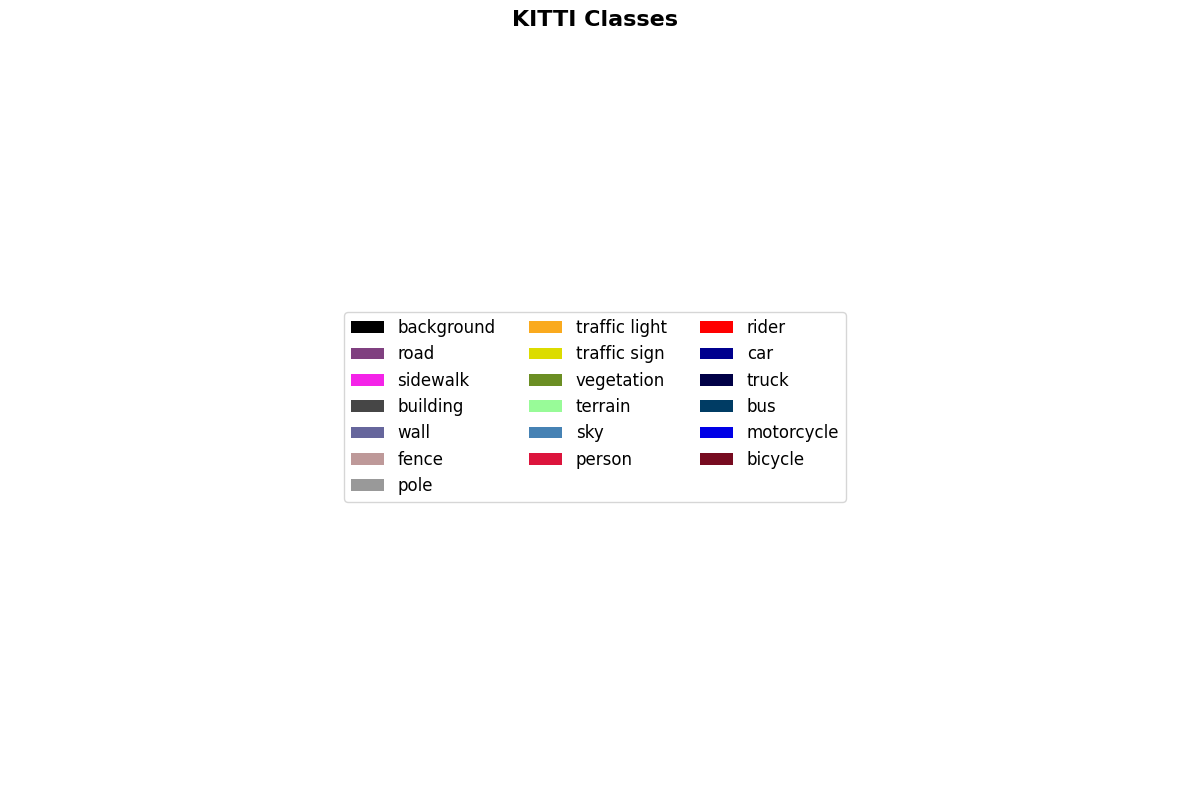

Processing image: 000000_10.png


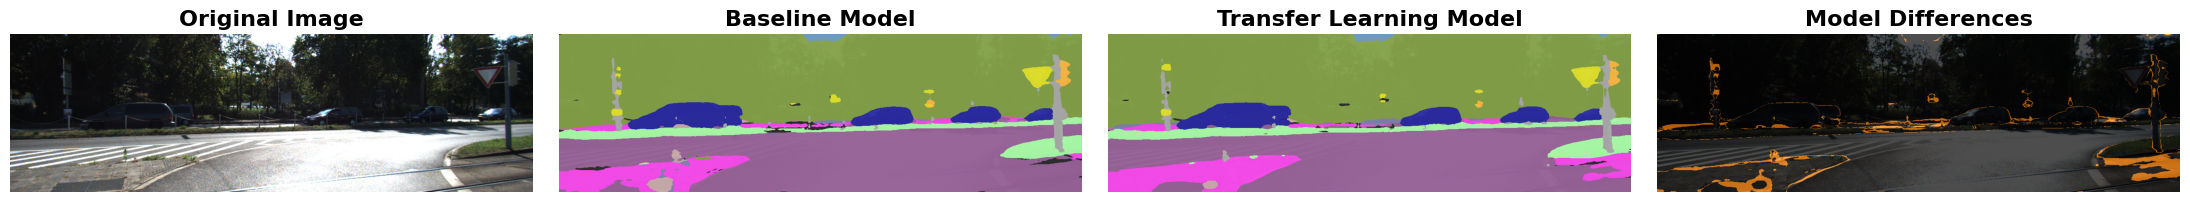


Image: 000000_10.png
Differences: 20924 pixels (4.49% of image)

Top 5 classes with biggest changes:
1. sidewalk: +28.5% (25449 → 32694 pixels)
2. road: -3.0% (144159 → 139824 pixels)
3. background: -58.5% (3350 → 1390 pixels)
4. fence: -69.8% (2472 → 747 pixels)
5. terrain: +5.1% (23699 → 24911 pixels)


In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import albumentations as A
from albumentations.pytorch import ToTensorV2
from glob import glob

# Define paths - update these as needed
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"
KITTI_DIR = os.path.join(BASE_DIR, "KITTI")
BASELINE_MODEL_PATH = os.path.join(KITTI_DIR, "checkpoints/baseline/best_model_miou_0.5117.pth")
TRANSFER_MODEL_PATH = os.path.join(KITTI_DIR, "checkpoints/transfer/best_model_miou_0.5342.pth")
TEST_DIR = os.path.join(KITTI_DIR, "testing/image_2")

# If no test images, use validation images
if not os.path.exists(TEST_DIR) or len(os.listdir(TEST_DIR)) == 0:
    TEST_DIR = os.path.join(KITTI_DIR, "validation/image_2")
    print(f"Using validation images from {TEST_DIR}")
else:
    print(f"Using test images from {TEST_DIR}")

# KITTI Reduced Class Mapping with improved, more visually distinct colors
KITTI_REDUCED_CLASSES = {
    0: {'name': 'background', 'color': (0, 0, 0)},
    1: {'name': 'road', 'color': (128, 64, 128)},
    2: {'name': 'sidewalk', 'color': (244, 35, 232)},
    3: {'name': 'building', 'color': (70, 70, 70)},
    4: {'name': 'wall', 'color': (102, 102, 156)},
    5: {'name': 'fence', 'color': (190, 153, 153)},
    6: {'name': 'pole', 'color': (153, 153, 153)},
    7: {'name': 'traffic light', 'color': (250, 170, 30)},
    8: {'name': 'traffic sign', 'color': (220, 220, 0)},
    9: {'name': 'vegetation', 'color': (107, 142, 35)},
    10: {'name': 'terrain', 'color': (152, 251, 152)},
    11: {'name': 'sky', 'color': (70, 130, 180)},
    12: {'name': 'person', 'color': (220, 20, 60)},
    13: {'name': 'rider', 'color': (255, 0, 0)},
    14: {'name': 'car', 'color': (0, 0, 142)},
    15: {'name': 'truck', 'color': (0, 0, 70)},
    16: {'name': 'bus', 'color': (0, 60, 100)},
    17: {'name': 'motorcycle', 'color': (0, 0, 230)},
    18: {'name': 'bicycle', 'color': (119, 11, 32)}
}

# Model params
IMAGE_HEIGHT = 1024
IMAGE_WIDTH = 1024
MODEL_TYPE = "b3"
NUM_CLASSES = len(KITTI_REDUCED_CLASSES)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Image preprocessing
test_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Initialize feature extractor
feature_extractor = SegformerImageProcessor.from_pretrained(
    f"nvidia/mit-{MODEL_TYPE}",
    do_reduce_labels=True,
    do_rescale=False,
    size={"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH}
)

def load_model(checkpoint_path):
    """Load and prepare model from checkpoint with multiple fallback methods"""
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None
        
    print(f"Loading model from: {checkpoint_path}")
    model = SegformerForSemanticSegmentation.from_pretrained(
        f"nvidia/mit-{MODEL_TYPE}",
        num_labels=NUM_CLASSES,
        id2label={str(i): KITTI_REDUCED_CLASSES[i]['name'] for i in range(NUM_CLASSES)},
        label2id={KITTI_REDUCED_CLASSES[i]['name']: i for i in range(NUM_CLASSES)},
        ignore_mismatched_sizes=True
    ).to(device)
    
    # Try multiple loading methods
    checkpoint = None
    try:
        print("Trying load method 1: weights_only=False")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    except Exception as e1:
        print(f"Method 1 failed: {str(e1)}")
        try:
            print("Trying load method 2: pickle_module=pickle")
            import pickle
            checkpoint = torch.load(checkpoint_path, map_location=device, pickle_module=pickle)
        except Exception as e2:
            print(f"Method 2 failed: {str(e2)}")
            try:
                print("Trying load method 3: alternative file extension")
                # Try alternative file extension (.pt or .pth)
                alt_path = checkpoint_path.replace('.pt', '.pth') if checkpoint_path.endswith('.pt') else checkpoint_path.replace('.pth', '.pt')
                print(f"Trying alternative path: {alt_path}")
                checkpoint = torch.load(alt_path, map_location=device, weights_only=False)
            except Exception as e3:
                print(f"Method 3 failed: {str(e3)}")
                print("All loading methods failed. Unable to load checkpoint.")
                return None
    
    if checkpoint is not None:
        print("Successfully loaded checkpoint!")
        # Determine the format of the checkpoint
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        
        model.eval()
        return model
    
    return None

# Load models
baseline_model = load_model(BASELINE_MODEL_PATH)
transfer_model = load_model(TRANSFER_MODEL_PATH)

# Create class legend
def display_class_legend():
    """Show a legend with class colors and names"""
    plt.figure(figsize=(12, 8))
    patches = []
    class_names = []
    for i in range(len(KITTI_REDUCED_CLASSES)):
        color = np.array(KITTI_REDUCED_CLASSES[i]['color']) / 255.0
        name = KITTI_REDUCED_CLASSES[i]['name']
        class_names.append(name)
        patches.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=name))
    
    # Create a cleaner, more organized legend
    plt.legend(handles=patches, loc='center', ncol=3, fontsize=12)
    plt.axis('off')
    plt.title('KITTI Classes', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

# Enhanced visualization function
def visualize_comparison(image_path, baseline_model, transfer_model):
    """Visualize and compare predictions from baseline and transfer learning models"""
    img_name = os.path.basename(image_path)
    print(f"Processing image: {img_name}")
    
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Cannot read image {image_path}")
        return
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]
    
    # Preprocess image
    transformed = test_transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)
    
    # Initialize prediction masks
    baseline_pred = None
    transfer_pred = None
    baseline_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
    transfer_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
    
    # Get baseline model prediction
    if baseline_model is not None:
        with torch.no_grad():
            outputs = baseline_model(pixel_values=image_tensor)
            logits = outputs.logits
            upsampled_logits = F.interpolate(
                logits, 
                size=(orig_h, orig_w),
                mode="bilinear",
                align_corners=False
            )
            baseline_pred = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
            
            # Create colored mask with better visualization
            for class_id, class_info in KITTI_REDUCED_CLASSES.items():
                mask = (baseline_pred == class_id)
                baseline_mask[mask] = class_info['color']
    
    # Get transfer learning model prediction
    if transfer_model is not None:
        with torch.no_grad():
            outputs = transfer_model(pixel_values=image_tensor)
            logits = outputs.logits
            upsampled_logits = F.interpolate(
                logits,
                size=(orig_h, orig_w),
                mode="bilinear",
                align_corners=False
            )
            transfer_pred = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
            
            # Create colored mask with better visualization
            for class_id, class_info in KITTI_REDUCED_CLASSES.items():
                mask = (transfer_pred == class_id)
                transfer_mask[mask] = class_info['color']
    
    # Compute differences (if both models available)
    if baseline_pred is not None and transfer_pred is not None:
        # Create a nicer visualization of differences
        diff_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
        diff = (baseline_pred != transfer_pred)
        
        # Highlight differences with a bright color and add transparency
        diff_overlay = np.zeros_like(image)
        diff_overlay[diff] = [255, 127, 0]  # Bright orange for differences
    
    # Create enhanced visualization with improved layout
    fig, axes = plt.subplots(1, 4 if (baseline_pred is not None and transfer_pred is not None) else 3, 
                          figsize=(22, 8))
    
    # Original image with better contrast
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=16, weight='bold')
    axes[0].axis('off')
    
    if baseline_model is not None:
        # Add a slight overlay of the original image to provide context
        baseline_blend = baseline_mask.copy()
        # Apply segmentation with slight transparency
        axes[1].imshow(image, alpha=0.2)
        axes[1].imshow(baseline_mask, alpha=0.8)
        axes[1].set_title('Baseline Model', fontsize=16, weight='bold')
        axes[1].axis('off')
    
    if transfer_model is not None:
        # Add a slight overlay of the original image to provide context
        transfer_blend = transfer_mask.copy()
        # Apply segmentation with slight transparency
        axes[2].imshow(image, alpha=0.2)
        axes[2].imshow(transfer_mask, alpha=0.8)
        axes[2].set_title('Transfer Learning Model', fontsize=16, weight='bold')
        axes[2].axis('off')
    
    if baseline_pred is not None and transfer_pred is not None:
        # Show differences with clearer visualization
        axes[3].imshow(image)
        axes[3].imshow(diff_overlay, alpha=0.7)
        axes[3].set_title('Model Differences', fontsize=16, weight='bold')
        axes[3].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)
    plt.show()
    
    # Calculate and display metrics
    if baseline_pred is not None and transfer_pred is not None:
        # Count pixels where models differ
        diff_pixels = np.sum(baseline_pred != transfer_pred)
        total_pixels = baseline_pred.size
        diff_percentage = (diff_pixels / total_pixels) * 100
        
        # Calculate class-wise differences
        class_diffs = {}
        for class_id in KITTI_REDUCED_CLASSES:
            b_count = np.sum(baseline_pred == class_id)
            t_count = np.sum(transfer_pred == class_id)
            if b_count > 0 or t_count > 0:
                diff = t_count - b_count
                class_diffs[KITTI_REDUCED_CLASSES[class_id]['name']] = {
                    'baseline': b_count,
                    'transfer': t_count,
                    'diff': diff,
                    'diff_percent': (diff / max(1, b_count)) * 100 if b_count > 0 else float('inf')
                }
        
        print(f"\nImage: {img_name}")
        print(f"Differences: {diff_pixels} pixels ({diff_percentage:.2f}% of image)")
        
        # Show top 5 classes with the biggest differences
        print("\nTop 5 classes with biggest changes:")
        sorted_diffs = sorted(
            [(k, v) for k, v in class_diffs.items() if abs(v['diff']) > 0], 
            key=lambda x: abs(x[1]['diff']), 
            reverse=True
        )
        
        for i, (class_name, stats) in enumerate(sorted_diffs[:5]):
            direction = "+" if stats['diff'] > 0 else "-"
            print(f"{i+1}. {class_name}: {direction}{abs(stats['diff_percent']):.1f}% " +
                  f"({stats['baseline']} → {stats['transfer']} pixels)")
    
    return baseline_pred, transfer_pred

# Find test images
test_images = sorted(glob(os.path.join(TEST_DIR, "*.png")))
if len(test_images) == 0:
    print(f"No images found in {TEST_DIR}")
else:
    print(f"Found {len(test_images)} images")
    
    # Show class legend
    display_class_legend()
    
    # Allow the user to select the image index or loop through multiple images
    image_indices = [0]  # Default to first image; modify this list to view multiple images
    
    for idx in image_indices:
        if idx < len(test_images):
            visualize_comparison(test_images[idx], baseline_model, transfer_model)
        else:
            print(f"Index {idx} out of range (max: {len(test_images)-1})")

Using test images from /home/thatkar/projects/def-saadi/thatkar/KITTI/testing/image_2
Using device: cuda
Loading model from: /home/thatkar/projects/def-saadi/thatkar/KITTI/checkpoints/baseline/best_model_miou_0.5117.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trying load method 1: weights_only=False
Successfully loaded checkpoint!
Loading model from: /home/thatkar/projects/def-saadi/thatkar/KITTI/checkpoints/transfer/best_model_miou_0.5342.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trying load method 1: weights_only=False
Successfully loaded checkpoint!
Found 200 images


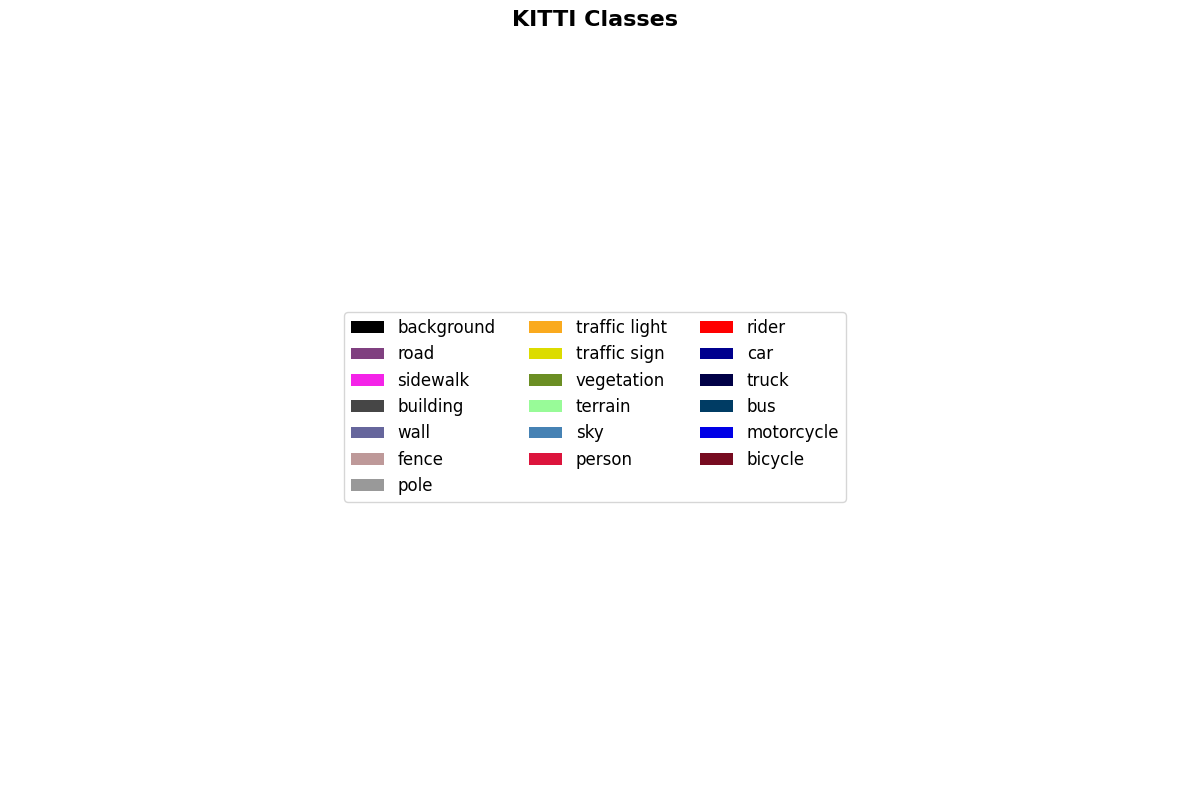

Processing image: 000000_10.png


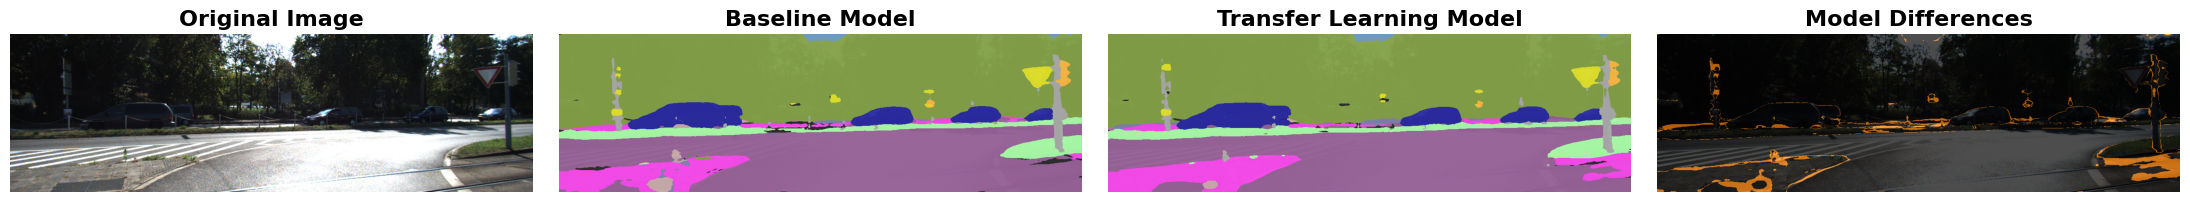


Image: 000000_10.png
Differences: 20924 pixels (4.49% of image)

Top 5 classes with biggest changes:
1. sidewalk: +28.5% (25449 → 32694 pixels)
2. road: -3.0% (144159 → 139824 pixels)
3. background: -58.5% (3350 → 1390 pixels)
4. fence: -69.8% (2472 → 747 pixels)
5. terrain: +5.1% (23699 → 24911 pixels)

Model Comparisons:
- Baseline Model
- Transfer Learning Model
- Model Differences


In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import albumentations as A
from albumentations.pytorch import ToTensorV2
from glob import glob

# Define paths - update these as needed
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"
KITTI_DIR = os.path.join(BASE_DIR, "KITTI")
BASELINE_MODEL_PATH = os.path.join(KITTI_DIR, "checkpoints/baseline/best_model_miou_0.5117.pth")
TRANSFER_MODEL_PATH = os.path.join(KITTI_DIR, "checkpoints/transfer/best_model_miou_0.5342.pth")
TEST_DIR = os.path.join(KITTI_DIR, "testing/image_2")

# If no test images, use validation images
if not os.path.exists(TEST_DIR) or len(os.listdir(TEST_DIR)) == 0:
    TEST_DIR = os.path.join(KITTI_DIR, "validation/image_2")
    print(f"Using validation images from {TEST_DIR}")
else:
    print(f"Using test images from {TEST_DIR}")

# KITTI Reduced Class Mapping with improved, more visually distinct colors
KITTI_REDUCED_CLASSES = {
    0: {'name': 'background', 'color': (0, 0, 0)},
    1: {'name': 'road', 'color': (128, 64, 128)},
    2: {'name': 'sidewalk', 'color': (244, 35, 232)},
    3: {'name': 'building', 'color': (70, 70, 70)},
    4: {'name': 'wall', 'color': (102, 102, 156)},
    5: {'name': 'fence', 'color': (190, 153, 153)},
    6: {'name': 'pole', 'color': (153, 153, 153)},
    7: {'name': 'traffic light', 'color': (250, 170, 30)},
    8: {'name': 'traffic sign', 'color': (220, 220, 0)},
    9: {'name': 'vegetation', 'color': (107, 142, 35)},
    10: {'name': 'terrain', 'color': (152, 251, 152)},
    11: {'name': 'sky', 'color': (70, 130, 180)},
    12: {'name': 'person', 'color': (220, 20, 60)},
    13: {'name': 'rider', 'color': (255, 0, 0)},
    14: {'name': 'car', 'color': (0, 0, 142)},
    15: {'name': 'truck', 'color': (0, 0, 70)},
    16: {'name': 'bus', 'color': (0, 60, 100)},
    17: {'name': 'motorcycle', 'color': (0, 0, 230)},
    18: {'name': 'bicycle', 'color': (119, 11, 32)}
}

# Model params
IMAGE_HEIGHT = 1024
IMAGE_WIDTH = 1024
MODEL_TYPE = "b3"
NUM_CLASSES = len(KITTI_REDUCED_CLASSES)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Image preprocessing
test_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Initialize feature extractor
feature_extractor = SegformerImageProcessor.from_pretrained(
    f"nvidia/mit-{MODEL_TYPE}",
    do_reduce_labels=True,
    do_rescale=False,
    size={"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH}
)

def load_model(checkpoint_path):
    """Load and prepare model from checkpoint with multiple fallback methods"""
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None
        
    print(f"Loading model from: {checkpoint_path}")
    model = SegformerForSemanticSegmentation.from_pretrained(
        f"nvidia/mit-{MODEL_TYPE}",
        num_labels=NUM_CLASSES,
        id2label={str(i): KITTI_REDUCED_CLASSES[i]['name'] for i in range(NUM_CLASSES)},
        label2id={KITTI_REDUCED_CLASSES[i]['name']: i for i in range(NUM_CLASSES)},
        ignore_mismatched_sizes=True
    ).to(device)
    
    # Try multiple loading methods
    checkpoint = None
    try:
        print("Trying load method 1: weights_only=False")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    except Exception as e1:
        print(f"Method 1 failed: {str(e1)}")
        try:
            print("Trying load method 2: pickle_module=pickle")
            import pickle
            checkpoint = torch.load(checkpoint_path, map_location=device, pickle_module=pickle)
        except Exception as e2:
            print(f"Method 2 failed: {str(e2)}")
            try:
                print("Trying load method 3: alternative file extension")
                # Try alternative file extension (.pt or .pth)
                alt_path = checkpoint_path.replace('.pt', '.pth') if checkpoint_path.endswith('.pt') else checkpoint_path.replace('.pth', '.pt')
                print(f"Trying alternative path: {alt_path}")
                checkpoint = torch.load(alt_path, map_location=device, weights_only=False)
            except Exception as e3:
                print(f"Method 3 failed: {str(e3)}")
                print("All loading methods failed. Unable to load checkpoint.")
                return None
    
    if checkpoint is not None:
        print("Successfully loaded checkpoint!")
        # Determine the format of the checkpoint
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        
        model.eval()
        return model
    
    return None

# Load models
baseline_model = load_model(BASELINE_MODEL_PATH)
transfer_model = load_model(TRANSFER_MODEL_PATH)

# Create class legend
def display_class_legend():
    """Show a legend with class colors and names"""
    plt.figure(figsize=(12, 8))
    patches = []
    class_names = []
    for i in range(len(KITTI_REDUCED_CLASSES)):
        color = np.array(KITTI_REDUCED_CLASSES[i]['color']) / 255.0
        name = KITTI_REDUCED_CLASSES[i]['name']
        class_names.append(name)
        patches.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=name))
    
    # Create a cleaner, more organized legend
    plt.legend(handles=patches, loc='center', ncol=3, fontsize=12)
    plt.axis('off')
    plt.title('KITTI Classes', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

# Enhanced visualization function
def visualize_comparison(image_path, baseline_model, transfer_model):
    """Visualize and compare predictions from baseline and transfer learning models"""
    img_name = os.path.basename(image_path)
    print(f"Processing image: {img_name}")
    
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Cannot read image {image_path}")
        return
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]
    
    # Preprocess image
    transformed = test_transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)
    
    # Initialize prediction masks
    baseline_pred = None
    transfer_pred = None
    baseline_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
    transfer_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
    
    # Get baseline model prediction
    if baseline_model is not None:
        with torch.no_grad():
            outputs = baseline_model(pixel_values=image_tensor)
            logits = outputs.logits
            upsampled_logits = F.interpolate(
                logits, 
                size=(orig_h, orig_w),
                mode="bilinear",
                align_corners=False
            )
            baseline_pred = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
            
            # Create colored mask with better visualization
            for class_id, class_info in KITTI_REDUCED_CLASSES.items():
                mask = (baseline_pred == class_id)
                baseline_mask[mask] = class_info['color']
    
    # Get transfer learning model prediction
    if transfer_model is not None:
        with torch.no_grad():
            outputs = transfer_model(pixel_values=image_tensor)
            logits = outputs.logits
            upsampled_logits = F.interpolate(
                logits,
                size=(orig_h, orig_w),
                mode="bilinear",
                align_corners=False
            )
            transfer_pred = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
            
            # Create colored mask with better visualization
            for class_id, class_info in KITTI_REDUCED_CLASSES.items():
                mask = (transfer_pred == class_id)
                transfer_mask[mask] = class_info['color']
    
    # Compute differences (if both models available)
    if baseline_pred is not None and transfer_pred is not None:
        # Create a nicer visualization of differences
        diff_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
        diff = (baseline_pred != transfer_pred)
        
        # Highlight differences with a bright color and add transparency
        diff_overlay = np.zeros_like(image)
        diff_overlay[diff] = [255, 127, 0]  # Bright orange for differences
    
    # Create enhanced visualization with improved layout
    fig, axes = plt.subplots(1, 4 if (baseline_pred is not None and transfer_pred is not None) else 3, 
                          figsize=(22, 8))
    
    # Original image with better contrast
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=16, weight='bold')
    axes[0].axis('off')
    
    if baseline_model is not None:
        # Add a slight overlay of the original image to provide context
        baseline_blend = baseline_mask.copy()
        # Apply segmentation with slight transparency
        axes[1].imshow(image, alpha=0.2)
        axes[1].imshow(baseline_mask, alpha=0.8)
        axes[1].set_title('Baseline Model', fontsize=16, weight='bold')
        axes[1].axis('off')
    
    if transfer_model is not None:
        # Add a slight overlay of the original image to provide context
        transfer_blend = transfer_mask.copy()
        # Apply segmentation with slight transparency
        axes[2].imshow(image, alpha=0.2)
        axes[2].imshow(transfer_mask, alpha=0.8)
        axes[2].set_title('Transfer Learning Model', fontsize=16, weight='bold')
        axes[2].axis('off')
    
    if baseline_pred is not None and transfer_pred is not None:
        # Show differences with clearer visualization
        axes[3].imshow(image)
        axes[3].imshow(diff_overlay, alpha=0.7)
        axes[3].set_title('Model Differences', fontsize=16, weight='bold')
        axes[3].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)
    plt.show()
    
    # Calculate and display metrics
    if baseline_pred is not None and transfer_pred is not None:
        # Count pixels where models differ
        diff_pixels = np.sum(baseline_pred != transfer_pred)
        total_pixels = baseline_pred.size
        diff_percentage = (diff_pixels / total_pixels) * 100
        
        # Calculate class-wise differences
        class_diffs = {}
        for class_id in KITTI_REDUCED_CLASSES:
            b_count = np.sum(baseline_pred == class_id)
            t_count = np.sum(transfer_pred == class_id)
            if b_count > 0 or t_count > 0:
                diff = t_count - b_count
                class_diffs[KITTI_REDUCED_CLASSES[class_id]['name']] = {
                    'baseline': b_count,
                    'transfer': t_count,
                    'diff': diff,
                    'diff_percent': (diff / max(1, b_count)) * 100 if b_count > 0 else float('inf')
                }
        
        # Print structured output
        print(f"\nImage: {img_name}")
        print(f"Differences: {diff_pixels} pixels ({diff_percentage:.2f}% of image)")
        
        # Show top 5 classes with the biggest differences
        print("\nTop 5 classes with biggest changes:")
        sorted_diffs = sorted(
            [(k, v) for k, v in class_diffs.items() if abs(v['diff']) > 0], 
            key=lambda x: abs(x[1]['diff']), 
            reverse=True
        )
        
        for i, (class_name, stats) in enumerate(sorted_diffs[:5]):
            direction = "+" if stats['diff'] > 0 else "-"
            print(f"{i+1}. {class_name}: {direction}{abs(stats['diff_percent']):.1f}% " +
                  f"({stats['baseline']} → {stats['transfer']} pixels)")
        
        # Print model comparisons
        print("\nModel Comparisons:")
        print("- Baseline Model")
        print("- Transfer Learning Model")
        print("- Model Differences")
    
    return baseline_pred, transfer_pred

# Find test images
test_images = sorted(glob(os.path.join(TEST_DIR, "*.png")))
if len(test_images) == 0:
    print(f"No images found in {TEST_DIR}")
else:
    print(f"Found {len(test_images)} images")
    
    # Show class legend
    display_class_legend()
    
    # Allow the user to select the image index or loop through multiple images
    image_indices = [0]  # Default to first image; modify this list to view multiple images
    
    for idx in image_indices:
        if idx < len(test_images):
            visualize_comparison(test_images[idx], baseline_model, transfer_model)
        else:
            print(f"Index {idx} out of range (max: {len(test_images)-1})")